# Gulf Coast Weather Prediction

## Machine Learning Model Building

Within this notebook we'll be building models that will determine whether we can predict rainfall in the Gulf Coast Area. We will be using the dataset we cleaned up in our other notebook.

## Imports

In [1]:
#standard packages
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as seabornInstance

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew
import datetime

import plotly.offline as py
import warnings
py.init_notebook_mode()
%matplotlib inline
plt.style.use('fivethirtyeight') # For plots

In [2]:
#Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot

#XGBoost
import xgboost

#skleran
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

C:\Users\Jimsyd\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Timeseries with Prophet - Rainfall

In [3]:
df_read= pd.read_csv('df_clean.csv')

In [4]:
#create timeseries features to show how trends are impacted by day of week, quarter, year, time of year.
ragp = df_read.copy()
ragp['datetime'] = pd.to_datetime(ragp['datetime'])
ragp = ragp[['datetime','City','Rainfall(in)']]
ragp.set_index('datetime', inplace=True)
ragp.drop('City', axis=1, inplace=True)
ragp

Rainfall(in)
datetime                
2010-01-01          0.00
2010-01-02          0.00
2010-01-03          0.00
2010-01-04          0.00
2010-01-05          0.00
...                  ...
2019-12-27          0.00
2019-12-28          0.32
2019-12-29          0.07
2019-12-30          0.00
2019-12-31          0.00

[18243 rows x 1 columns]

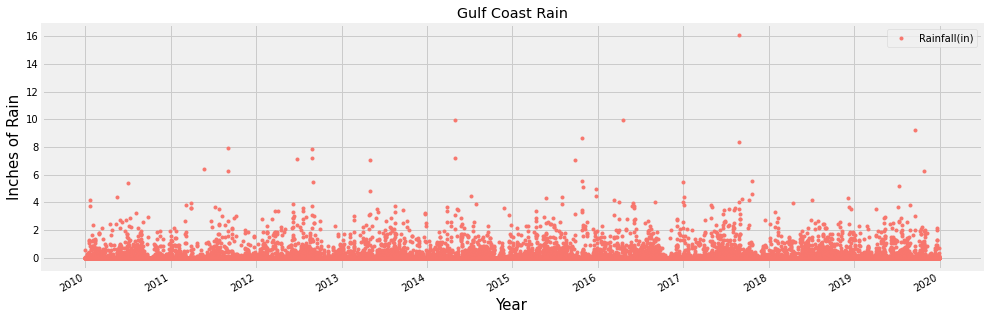

In [5]:
#quick visual to see our rainfalls over our decade of data points
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
ragp.plot(style='.', figsize=(15,5), color=color_pal[0], title='Gulf Coast Rain')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Inches of Rain', fontsize=15)
plt.show()

In [6]:
#create time series features to see how the trends are impacted by day, week, quarter, month, year
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['day'] = df['date'].apply(pd.to_datetime).dt.dayofweek
    df['quarter'] = df['date'].apply(pd.to_datetime).dt.quarter
    df['month'] = df['date'].apply(pd.to_datetime).dt.month
    df['year'] = df['date'].apply(pd.to_datetime).dt.year
    df['dayYear'] = df['date'].apply(pd.to_datetime).dt.dayofyear
    df['dayMonth'] = df['date'].apply(pd.to_datetime).dt.day
    df['weekYear'] = df['date'].apply(pd.to_datetime).dt.weekofyear
    
    X = df[['day','quarter','month','year',
           'dayYear','dayMonth','weekYear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(ragp, label='Rainfall(in)')

features_and_target = pd.concat([X, y], axis=1)

features_and_target.head()

day  quarter  month  year  dayYear  dayMonth  weekYear  \
datetime                                                             
2010-01-01    4        1      1  2010        1         1        53   
2010-01-02    5        1      1  2010        2         2        53   
2010-01-03    6        1      1  2010        3         3        53   
2010-01-04    0        1      1  2010        4         4         1   
2010-01-05    1        1      1  2010        5         5         1   

            Rainfall(in)  
datetime                  
2010-01-01           0.0  
2010-01-02           0.0  
2010-01-03           0.0  
2010-01-04           0.0  
2010-01-05           0.0

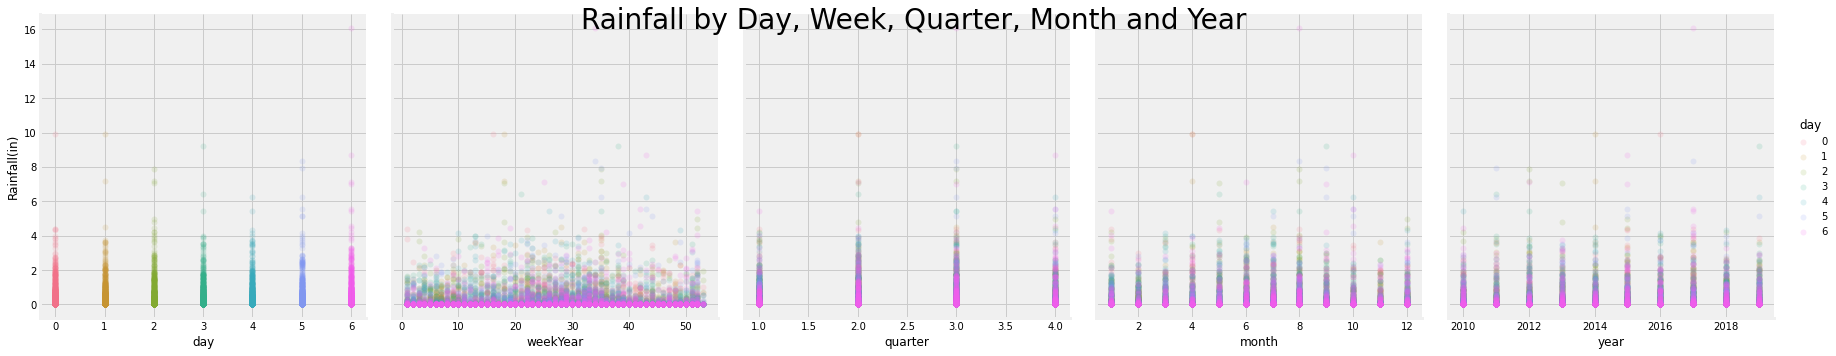

In [7]:
#plotting features to see trends
#Rainfall has strong monthly properties
plt.rcParams['figure.figsize']=(30,15)
sns.pairplot(features_and_target.dropna(),
             hue='day',
             x_vars=['day', 'weekYear','quarter', 'month',
                     'year'],
             y_vars='Rainfall(in)',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Rainfall by Day, Week, Quarter, Month and Year', fontsize=28)
plt.show()

### Create the input data for Prophet (Rainfall w/o outliers)

We'll be using our dataset that we already cleaning in our data wrangling section. We still need to manipulate it a bit to work with Prophet.

In [8]:
#prepare our dataset for Prophet timeseries
df = df_read.copy()

#Convert string datetime into readable datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

#create dataframe with columns that we'll be using
df = df[['datetime','Dewpoint_temp(°F)','Humidity(%)','Sealevel_pressure(Hg)','Max_temp(°F)','Min_temp(°F)',
           'Average_temp(°F)', 'Wind_speed(mph)','Rainfall(in)']]

#set index to datetime
df.set_index('datetime', inplace=True)

print(df.shape)

(18243, 8)


In [9]:
#remove outliers above 5.5 inches of rain 
df= df[df['Rainfall(in)'] < 5.5]
df.shape

(18225, 8)

In [10]:
#create input features and target variable
#drop feature
X= df.drop('Rainfall(in)', axis=1)

#include features
y= df['Rainfall(in)']

In [11]:
#importances of our values in correlation to their impact on rainfall
importances= X.apply(lambda x: x.corr(y))
indices= np.argsort(importances)
print(importances[indices])

Sealevel_pressure(Hg)   -0.194383
Max_temp(°F)             0.007984
Average_temp(°F)         0.064095
Min_temp(°F)             0.109440
Dewpoint_temp(°F)        0.159427
Wind_speed(mph)          0.326622
Humidity(%)              0.331100
dtype: float64


***As we can see, wind speed and humidity have the biggest correlation with rainfall.***

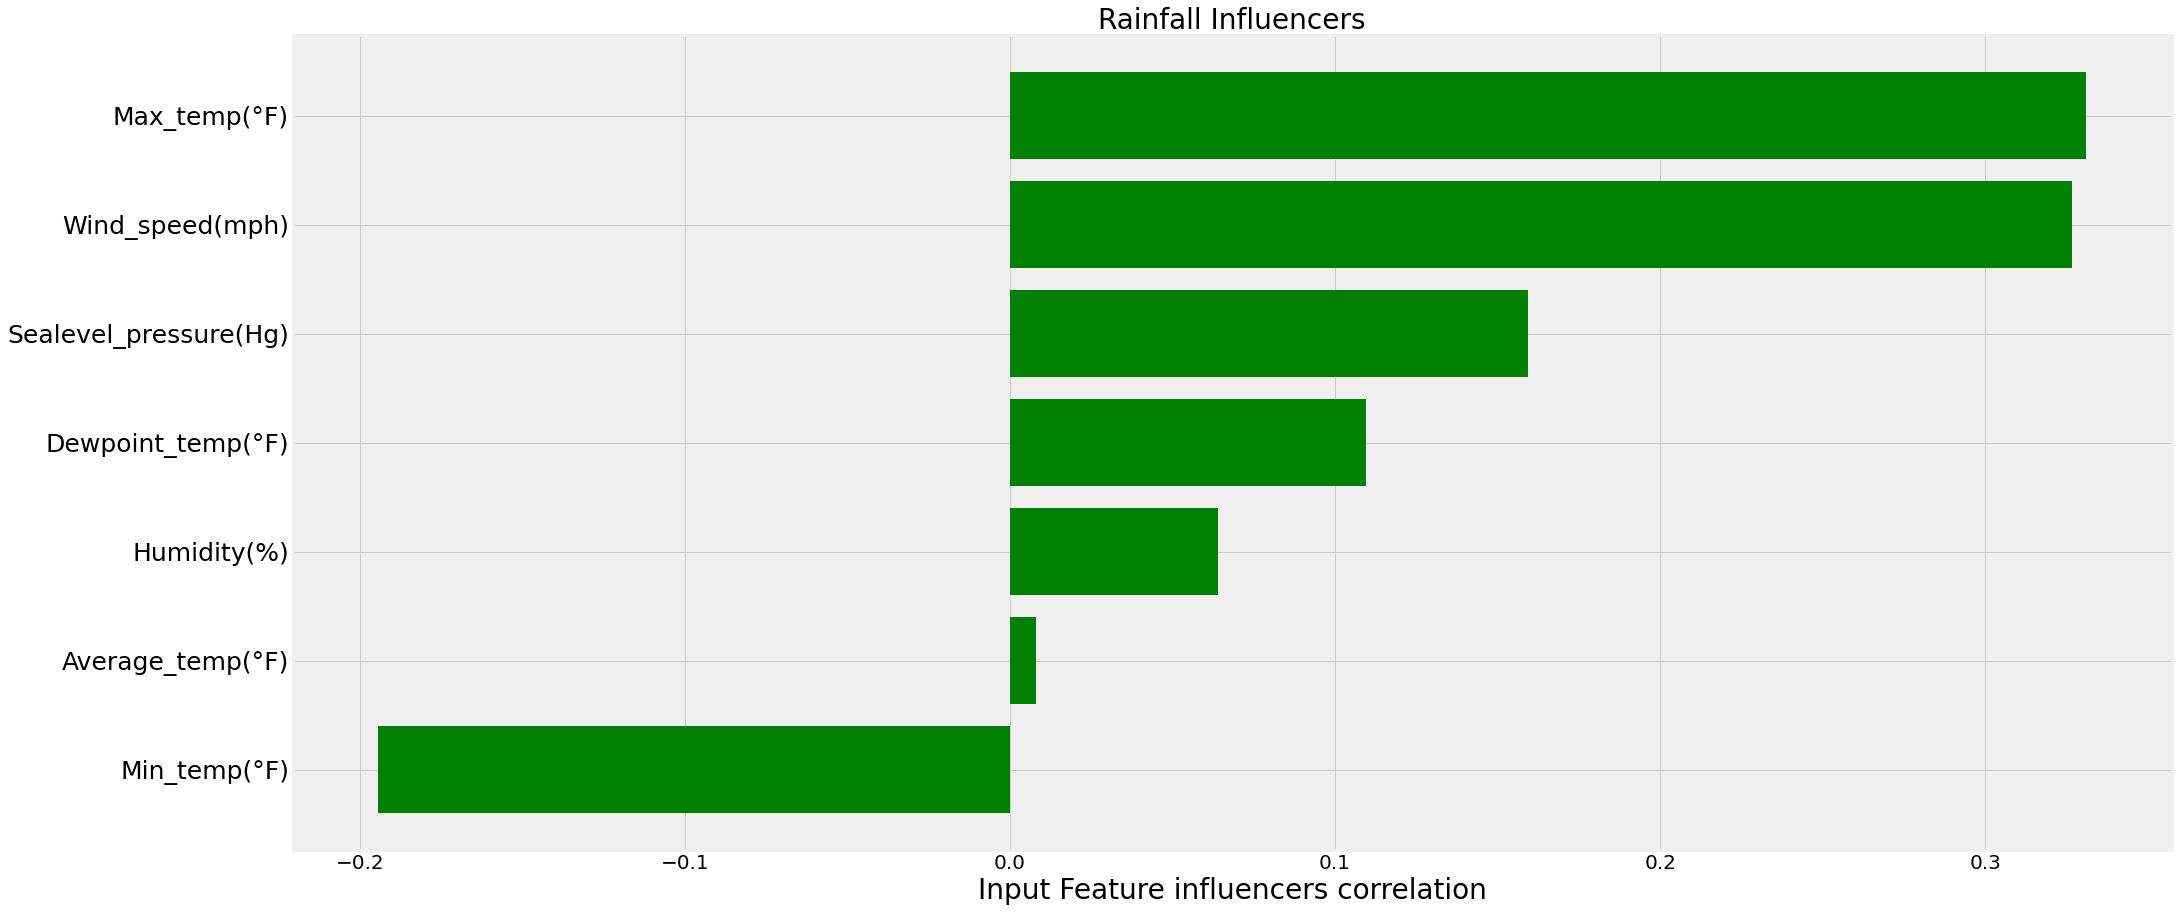

In [12]:
names=['Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
       'Dewpoint_temp(°F)', 'Humidity(%)', 'Wind_speed(mph)', 'type']
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.title('Rainfall Influencers', fontsize=28)
plt.yticks(range(len(indices)), [names[i] for i in indices], fontsize=25)
plt.xticks(fontsize=20)
plt.xlabel('Input Feature influencers correlation', fontsize=28)
plt.show()

In [13]:
#create dataframe off original dataset, remove outliers
df1 = df_read.copy()
#drop outliers above 5.5 inches of rain
df1= df1[df1['Rainfall(in)'] < 5.5]

#create input features and target variable from dataset with datetime
#drop feature
X= df1.drop('Rainfall(in)', axis=1)

#include features
y= df1['Rainfall(in)']

In [14]:
#create dataframe with ds(datestamp) and y(predicted numeric column)
train_dataset= pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(X["datetime"])
train_dataset['y']=y
train_dataset.head(2)

ds    y
0 2010-01-01  0.0
1 2010-01-02  0.0

In [15]:
#create and fit model with default values
# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet_basic = Prophet(interval_width=0.95)

#fit model
prophet_basic.fit(train_dataset)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
#predict values for the future
future= prophet_basic.make_future_dataframe(periods=731)
future.tail(5)

ds
18951 2021-12-27
18952 2021-12-28
18953 2021-12-29
18954 2021-12-30
18955 2021-12-31

***We set our future at 2 years(731 days) past our original dataset. Our future contains 18973 rows and will predict into the future (2021-12-31)***

In [17]:
#create forecast of future
forecast=prophet_basic.predict(future)

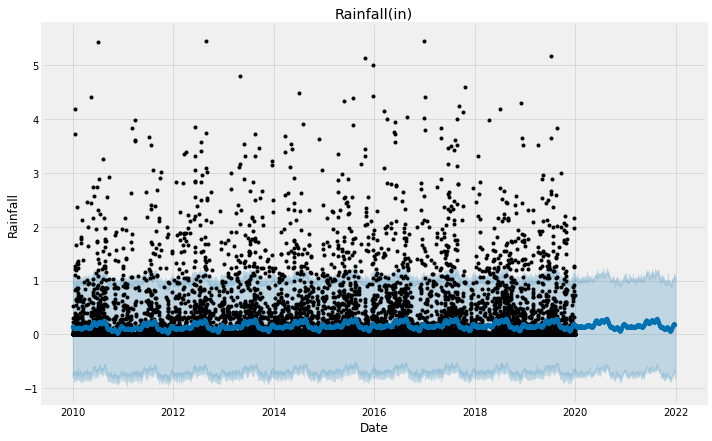

In [18]:
#plot predicted data
fig1 =prophet_basic.plot(forecast, xlabel='Date', ylabel='Rainfall')
plt.title('Rainfall(in)')
plt.show()

***The blue lines represent the forecasted values and the uncertainty intervals of the forecasts are the blue shaded regions.***

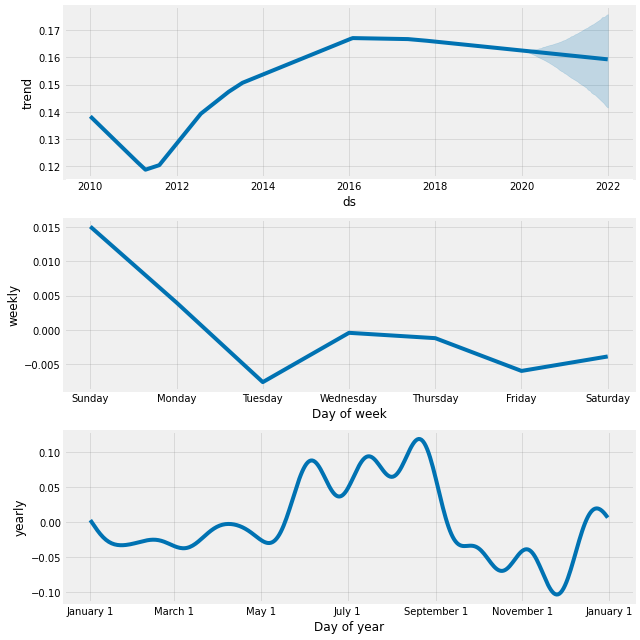

In [19]:
#plot the forecasted components
fig2 = prophet_basic.plot_components(forecast)

***The first plot shows that the monthly volume of rainfall dropped in 2011 but steadily increased until 2016 when it started to decrease slightly each year. This graph shows that there looks to be a downward trend for the next following years.***

***The second plot shows a mostly decrease in weekly trends. Day of the week isn't commonly a factor in weather though.***

***Our final plot is interesting because traditionally weather is affected by seasonal habits. As we can see in our plot, the warmer months of May-September were higher than the rest of the year but there were dips within those months.***

Text(0.5, 1.0, 'Rainfall Prediction with ChangePoints')

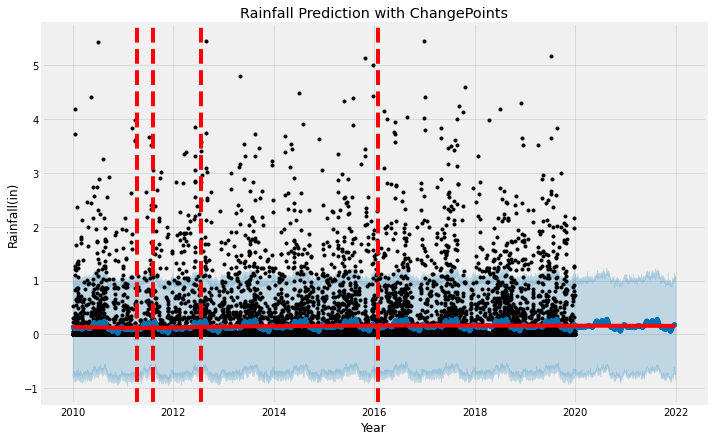

In [20]:
#Prophet detects changepoints by first specifying a large number of potential ChangePoints at which the rate is allowed to change
fig = prophet_basic.plot(forecast, xlabel='Year', ylabel='Rainfall(in)')
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)
plt.title('Rainfall Prediction with ChangePoints')

In [21]:
#view the dates where the ChangePoints occurred
prophet_basic.changepoints

583     2010-04-27
1166    2010-08-22
1749    2010-12-16
2333    2011-04-12
2916    2011-08-07
3499    2011-12-02
4082    2012-03-29
4665    2012-07-24
5248    2012-11-18
5832    2013-03-14
6415    2013-07-09
6998    2013-11-03
7581    2014-03-01
8164    2014-06-26
8747    2014-10-20
9331    2015-02-15
9914    2015-06-12
10497   2015-10-06
11080   2016-01-31
11663   2016-05-27
12246   2016-09-21
12830   2017-01-16
13413   2017-05-12
13996   2017-09-06
14579   2018-01-01
Name: ds, dtype: datetime64[ns]

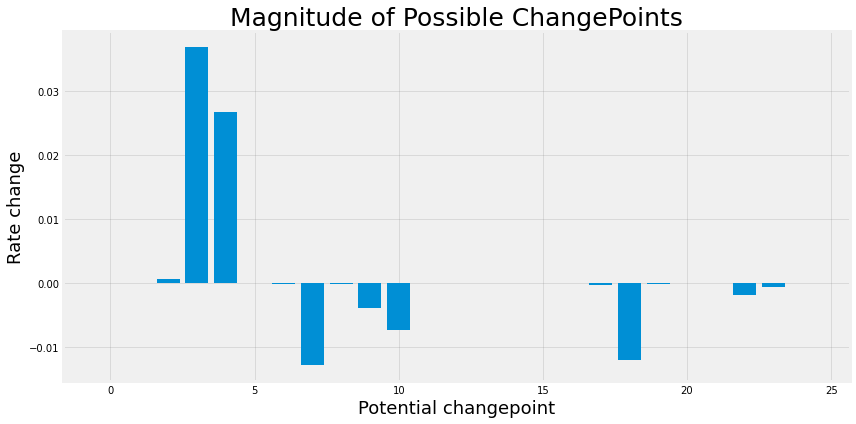

In [22]:
#look at the magnitudes of these possible changepoints
deltas = prophet_basic.params['delta'].mean(0)
fig = plt.figure(figsize=(12,6),facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_title('Magnitude of Possible ChangePoints', fontsize=25)
ax.set_ylabel('Rate change', fontsize=18)
ax.set_xlabel('Potential changepoint', fontsize=18)
fig.tight_layout()

***The changepoints are datetime points where the time series have abrupt changes in their trajectory. In this graph we can see where we had positive rate changes and negative changes.***

### Ajusting Trend

By default the scale is set to 0.05 so we'll adjust the trend to be more flexible by increasing the value and then by decreasing the value.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Rainfall Prediction Decreased ChangePoint Prior Scale')

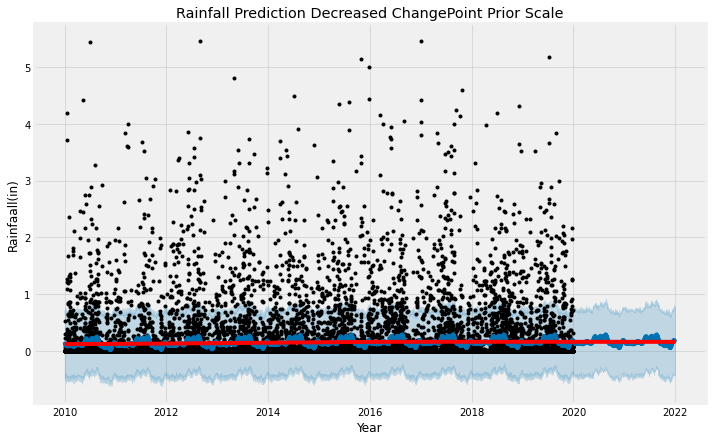

In [23]:
#decrease the ChangePoint prior scale
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.02)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast, xlabel= 'Year', ylabel='Rainfaall(in)');
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)
plt.title('Rainfall Prediction Decreased ChangePoint Prior Scale')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Rainfall Prediction Increased ChangePoint Prior Scale')

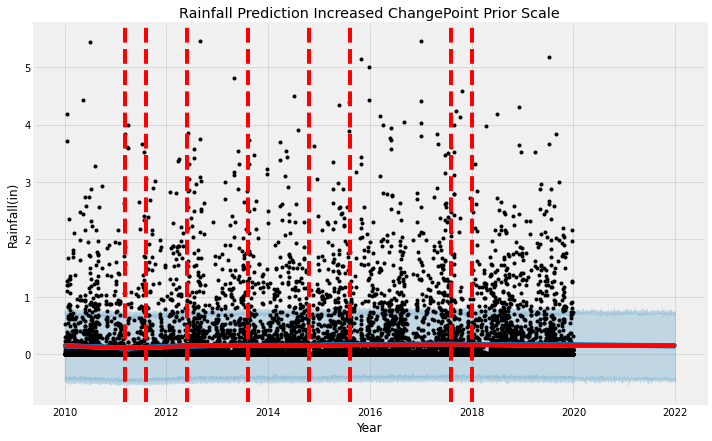

In [24]:
#increase the ChangePoint prior scale
pro_change= Prophet(n_changepoints=20, yearly_seasonality=False, changepoint_prior_scale=0.08)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast, xlabel= 'Year', ylabel='Rainfall(in)');
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)
plt.title('Rainfall Prediction Increased ChangePoint Prior Scale')

***Prophet allows us to adjust the trend in case there is an overfit or underfit. The changepoint_prior_scale helps us adjust the strength of the trend. For the 2nd model we increase the scale to 0.08 to make the trend more flexible. Our 1st model has a scale of 0.02 to make the trend less flexible.***

In [25]:
#view the dates where the ChangePoints occurred
pro_change.changepoints

729     2010-05-26
1458    2010-10-19
2187    2011-03-14
2916    2011-08-07
3645    2012-01-01
4374    2012-05-26
5103    2012-10-20
5832    2013-03-14
6561    2013-08-08
7290    2014-01-01
8018    2014-05-27
8747    2014-10-20
9476    2015-03-16
10205   2015-08-09
10934   2016-01-02
11663   2016-05-27
12392   2016-10-20
13121   2017-03-15
13850   2017-08-08
14579   2018-01-01
Name: ds, dtype: datetime64[ns]

***Our graphs did a good job of predicting a base amount of rainfall for the next 2 years. We can fine tune it a bit more to get more precise blue lines and blue shaded area.***

Eventhough we took out our rainfall outliers that mostly consisted of rainfall correlated with hurricanes or tropical storms hitting the area, we'll create a hurricane season promo then run it through our prophet model to see if the area was affected.

In [26]:
#looking at hurricane season factored in
#Hurricane season (06-01 to 11-30)
hurricane_season = pd.DataFrame({'holiday': "hurricane season",
                      'ds' : pd.to_datetime(['2010-06-01','2011-06-01','2012-06-01','2013-06-01',
                                            '2014-06-01','2015-06-01','2016-06-01','2017-06-01',
                                            '2018-06-01','2019-06-01']),
                      'lower_window': 0,
                      'upper_window': 162})

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


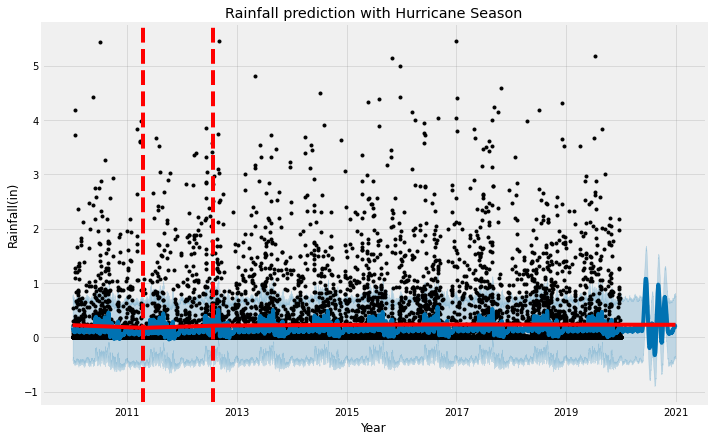

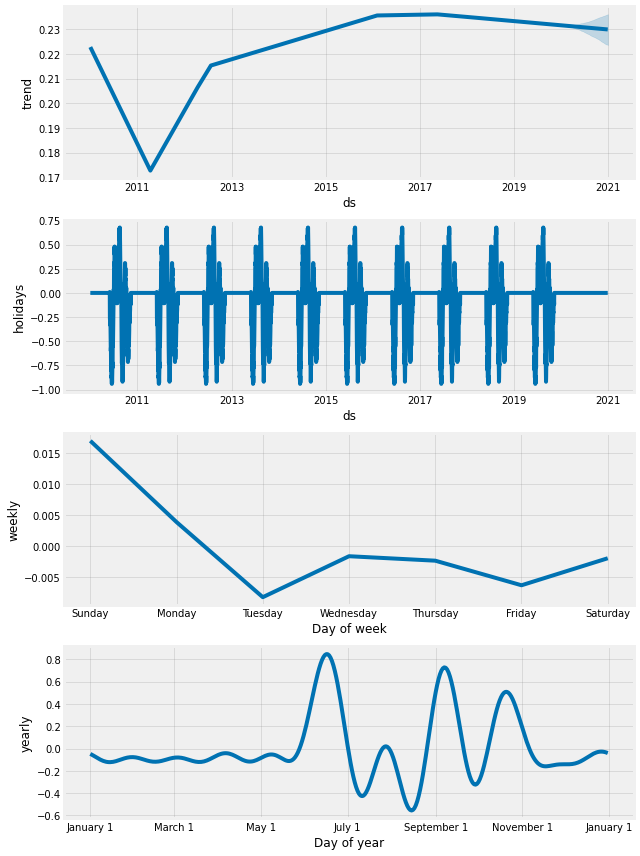

In [27]:
prophet = Prophet(holidays=hurricane_season)
prophet.fit(train_dataset)
future = prophet.make_future_dataframe(periods=365, freq='D')

forecast = prophet.predict(future)
fig = prophet.plot(forecast, xlabel='Year', ylabel='Rainfall(in)')
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.title('Rainfall prediction with Hurricane Season')
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

***Our graphs show some changes from our previous trend graphs.***

***The first graph shows a deep dropped in 2011 with a steep rebound and steady climb following that up until 2018 when a slight, steady decrease began. Our model shows this decline to continue.***

***Our yearly graph shows a consistent ripple like trend but then a jump starting in June with some steep upwards and downward trends through till December. Considering this is during our traditional hurricane months, more research could be done by looking at periods of non rain bookending hurricanes and tropical storms.***

In [28]:
#cross validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(prophet_basic, initial='730 days', period='90 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 29 forecasts with cutoffs between 2012-02-06 00:00:00 and 2018-12-31 00:00:00


ds     yhat  yhat_lower  yhat_upper     y     cutoff
0 2012-02-07  0.11645   -0.620955    0.833780  0.00 2012-02-06
1 2012-02-07  0.11645   -0.637290    0.915996  0.00 2012-02-06
2 2012-02-07  0.11645   -0.599866    0.909526  0.00 2012-02-06
3 2012-02-07  0.11645   -0.644469    0.839164  0.00 2012-02-06
4 2012-02-07  0.11645   -0.655846    0.852949  0.06 2012-02-06

In [29]:
# Python
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


horizon       mse      rmse       mae  mdape  coverage
0 37 days  0.225405  0.474768  0.244744    inf  0.949653
1 38 days  0.223978  0.473264  0.243955    inf  0.949954
2 39 days  0.222439  0.471634  0.243544    inf  0.950719
3 40 days  0.222167  0.471346  0.243779    inf  0.950805
4 41 days  0.223215  0.472457  0.245227    inf  0.949771

In [30]:
#create y_true and y_pred
y_true= df_cv.y
y_pred= df_cv.yhat

print('Mean square error: ', mean_squared_error(y_true, y_pred))
print('Mean absolute error: ', mean_absolute_error(y_true, y_pred))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))


ph_rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))

Mean square error:  0.21928234867860252
Mean absolute error:  0.24830709854988092
Root Mean Squared Error:  0.4682759322008793


***The Root Mean Square Error(RMSE) tells us that our model was able to forecast the average daily rainfall within 0.219282 of our actual rainfall.***

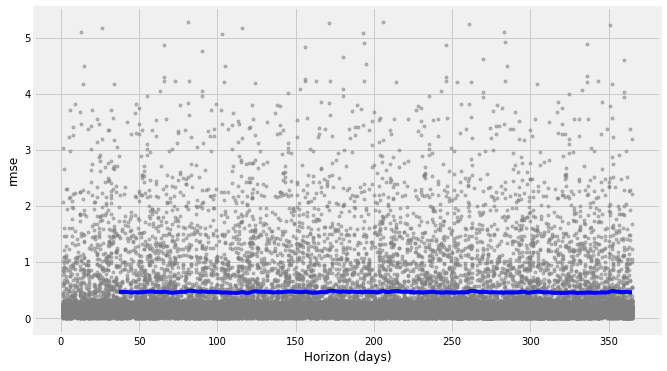

In [31]:
# Python
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

## Simple Linear Regression

In [32]:
#create our dataframe for Linear Regression starting with our cleaned dataset
df_lr = df_read.copy()

#we know that our outliers are mainly found above 6 inches of rain so we'll remove them from our dataset
df_lr= df_lr[df_lr['Rainfall(in)'] < 5.5]

In [33]:
df_lr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18225 entries, 0 to 18242
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   18225 non-null  object 
 1   datetime               18225 non-null  object 
 2   Dewpoint_temp(°F)      18225 non-null  float64
 3   Humidity(%)            18225 non-null  float64
 4   Sealevel_pressure(Hg)  18225 non-null  float64
 5   Max_temp(°F)           18225 non-null  float64
 6   Min_temp(°F)           18225 non-null  float64
 7   Average_temp(°F)       18225 non-null  float64
 8   Wind_speed(mph)        18225 non-null  float64
 9   Rainfall(in)           18225 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.5+ MB


Text(0.5, 1.0, 'Rainfall Distribution')

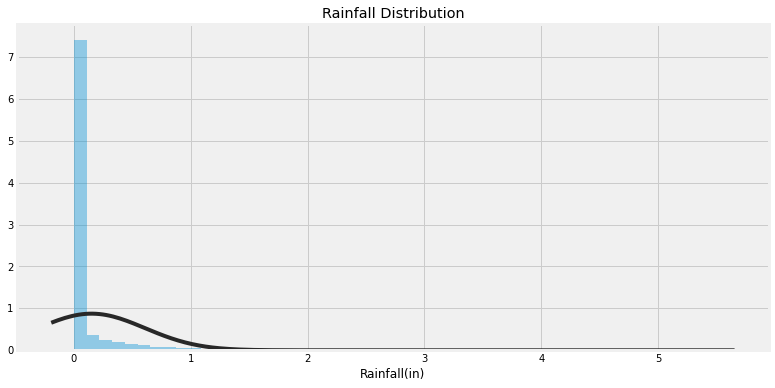

In [34]:
#plot our Rainfall value
plt.figure(figsize=(12,6))
plt.tight_layout()
seabornInstance.distplot(df_lr['Rainfall(in)'],fit=norm,kde=False)
plt.title('Rainfall Distribution')

***We can see that a majority of our days consisted of zero rainfall with amounts under 1" having a strong showing as well. Average looks to be around 0.01-0.02 inches***

In [35]:
#divide dataframe into independent variables(X) and dependent variables(y)
X = df_lr['Humidity(%)'].values.reshape(-1,1)
y = df_lr['Rainfall(in)'].values.reshape(-1,1)

In [36]:
#split 80% of our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [37]:
#train our algorithm
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[-0.83681432]
[[0.01345328]]


***We can see that for every one unit of change in Dewpoint temps, there is a minimal change in Rainfall.***

In [39]:
#make predictions with our test data
y_pred = regressor.predict(X_test)

In [40]:
#compare the actual output values with the predicted values
dl = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
dl

Actual  Predicted
0       0.00   0.218371
1       0.00   0.064555
2       0.00   0.091462
3       0.00   0.091462
4       0.00   0.037649
...      ...        ...
3640    0.00   0.145275
3641    2.01   0.436616
3642    0.00   0.104915
3643    0.36   0.145275
3644    1.78   0.199088

[3645 rows x 2 columns]

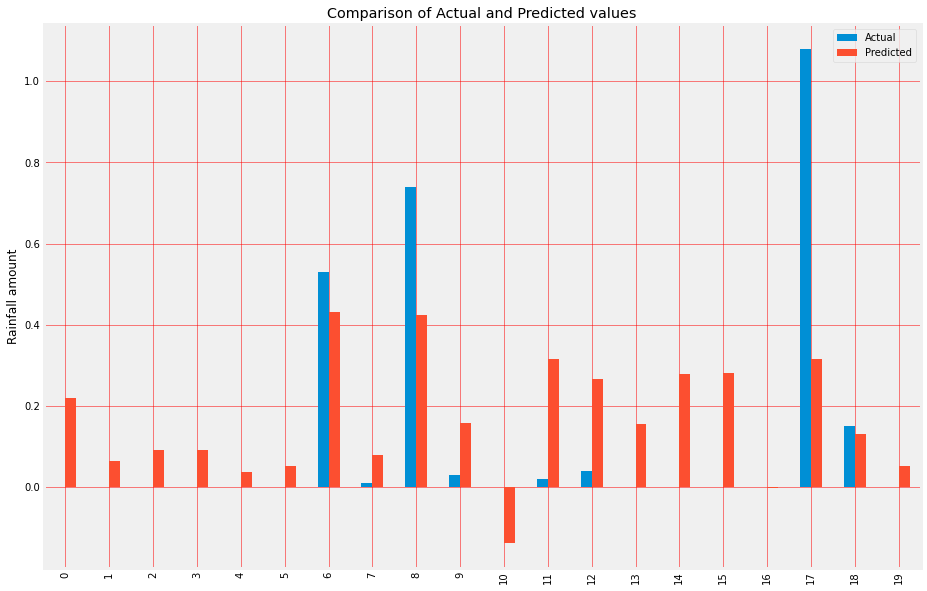

In [41]:
#we'll take a look at the 1st 20 records
dl1 = dl.head(20)
dl1.plot(kind='bar',figsize=(14,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Comparison of Actual and Predicted values')
plt.ylabel('Rainfall amount')
plt.show()

***We can see that our predicted precentages aren't close to our actual ones***

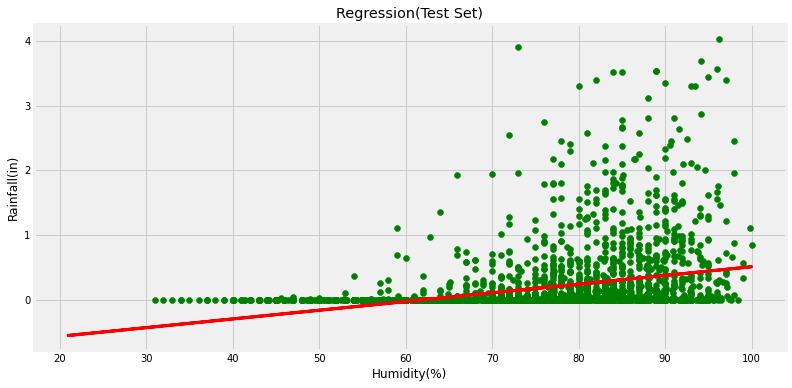

In [42]:
#plot straight line with the test data
plt.figure(figsize=(12,6))
plt.scatter(X_test,y_test,color="green") # Plot a graph with X_test vs y_test
plt.plot(X_train,regressor.predict(X_train),color="red",linewidth=3) # Regressior line showing
plt.title('Regression(Test Set)')
plt.xlabel('Humidity(%)')
plt.ylabel('Rainfall(in)')
plt.show()

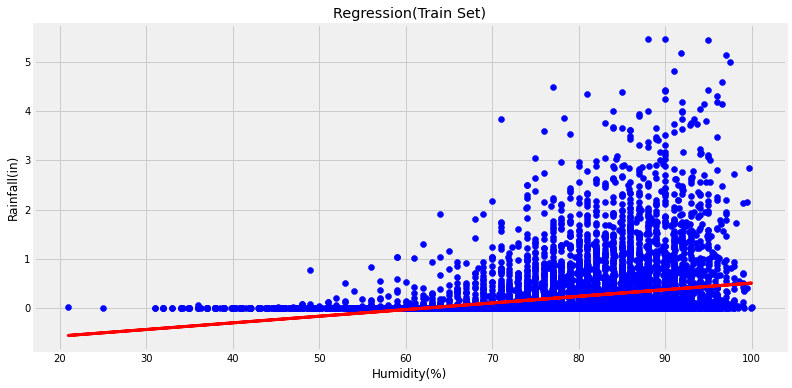

In [43]:
#plot straight line with the train data
plt.figure(figsize=(12,6))
plt.scatter(X_train,y_train,color="blue")  # Plot a graph with X_train vs y_train
plt.plot(X_train,regressor.predict(X_train),color="red",linewidth=3) # Regressior line showing
plt.title('Regression(Train Set)')
plt.xlabel('Humidity(%)')
plt.ylabel('Rainfall(in)')
plt.show()

***We can see that as Humidity raises so does our rainfall which isn't surprising since humidity and correlated to rainfall.***

In [44]:
#print mean absolute error, mean square error and root mean squared error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score: %.2f' % r2_score(y_test,y_pred))

Mean Absolute Error: 0.2303198905858845
Mean Squared Error: 0.16931549835352736
Root Mean Squared Error: 0.41147964512661783
R2 score: 0.11


***We can see that the value of the root mean squared error is 0.4269 which is more than 10% of the mean value of 73.605187. It can be better but still can make good predictions.***

## Multiple Linear Regression

In the last section we used a simple linear regression that left off most of our dataset. Here we'll included the other variables and hopefully get better results.

In [45]:
#we'll use the same dataframe as before
df_lr.describe()

Dewpoint_temp(°F)   Humidity(%)  Sealevel_pressure(Hg)  Max_temp(°F)  \
count       18225.000000  18225.000000           18225.000000  18225.000000   
mean           60.489591     73.611652              30.049389     79.981125   
std            13.937406     11.389341               0.140200     12.204181   
min             4.708333     21.000000              29.440000     31.000000   
25%            52.000000     67.000000              29.960000     72.000000   
50%            64.420000     75.000000              30.036250     82.000000   
75%            72.000000     82.000000              30.130000     90.000000   
max            80.000000    100.000000              30.695417    109.000000   

       Min_temp(°F)  Average_temp(°F)  Wind_speed(mph)  Rainfall(in)  
count  18225.000000      18225.000000     18225.000000  18225.000000  
mean      61.398848         70.940905        22.751056      0.152178  
std       14.034890         12.751942         6.916819      0.456351  
min       16.000000         26.000000         0.000000      0.000000  
25%       51.000000         62.000000        18.000000      0.000000  
50%       65.000000         74.000000        22.000000      0.000000  
75%       74.000000         82.000000        26.000000      0.030000  
max       85.000000         95.000000       120.000000      5.460000


 mu = 0.10 and sigma = 0.25



Text(0.5, 1.0, 'Rainfall Distribution')

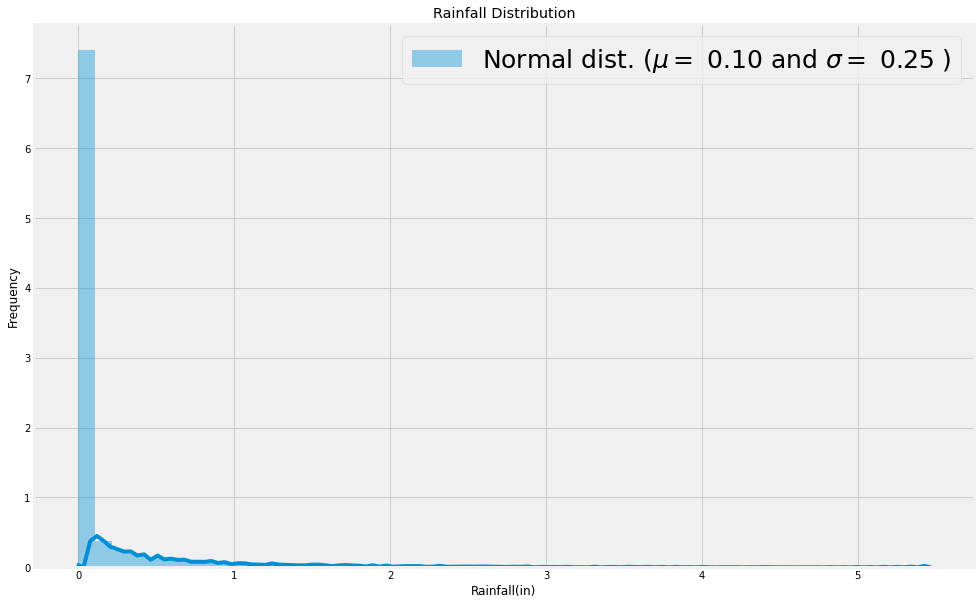

In [46]:
#fit parameters
(mu, sigma) = norm.fit(np.log1p(df_lr['Rainfall(in)']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#plot distribution
plt.figure(figsize=(15,10))
seabornInstance.distplot(df_lr['Rainfall(in)'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best', fontsize=25)
plt.ylabel('Frequency')
plt.title('Rainfall Distribution')

In [158]:
#divide dataframe into independent variables(X) and dependent variables(y)
X = df_lr[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_lr['Rainfall(in)']

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

#train our model
regressor = LinearRegression()

#fit our model
regressor.fit(X_train, y_train)

#predict our test model
y_pred = regressor.predict(X_test)

#predict our training model
y_pred1 = regressor.predict(X_train)

In [160]:
#model test score
lr_test = regressor.score(X_test, y_test)
print('Test score:  %.3f' % lr_rsq)

#model train score
lr_train = regressor.score(X_train, y_train)
print('Train score:  %.3f'% lr_rss)

Test score:  0.216
Train score:  0.220


In [53]:
#create dataframe of our features and their importances to dependent varaible(Rainfall)
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  

coeff_df

Coefficient
Dewpoint_temp(°F)        -0.016498
Humidity(%)               0.018145
Sealevel_pressure(Hg)    -0.199715
Max_temp(°F)             -0.002136
Min_temp(°F)              0.007524
Average_temp(°F)          0.008459
Wind_speed(mph)           0.019135

***For a unit incrase in Dewpoint temps, there is a decrease of -0.017 of Rainfall. A unit of decrease in Sealevel Pressure results a decrease of -0.22***

In [54]:
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))


train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  -2.553267530260082
Test r2 score:  0.21636323422646853
Train RMSE: 0.3983
Test RMSE: 0.4228


In [55]:
#difference between actual value and predicted value
dlf = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dlf1 = dlf.head(25)
dlf1

Actual  Predicted
5459     0.29   0.407852
11302    0.00   0.034684
3573     0.00   0.065726
4473     0.00   0.121085
15633    0.07   0.193132
1931     0.54   0.557368
9015     0.00   0.194925
8351     0.00  -0.116204
13614    0.00   0.170421
11255    0.00  -0.070206
6430     0.67   0.353878
16322    1.46   0.267527
1736     0.00   0.022484
17457    0.00   0.140462
16125    0.00  -0.208181
7522     0.01   0.224265
15782    0.55   0.429903
12058    0.00  -0.101334
13199    0.00   0.201096
16644    0.54   0.403799
11768    1.05   0.402286
13336    0.36   0.290261
13857    0.00  -0.048307
10458    0.57   0.438907
3422     0.00   0.356582

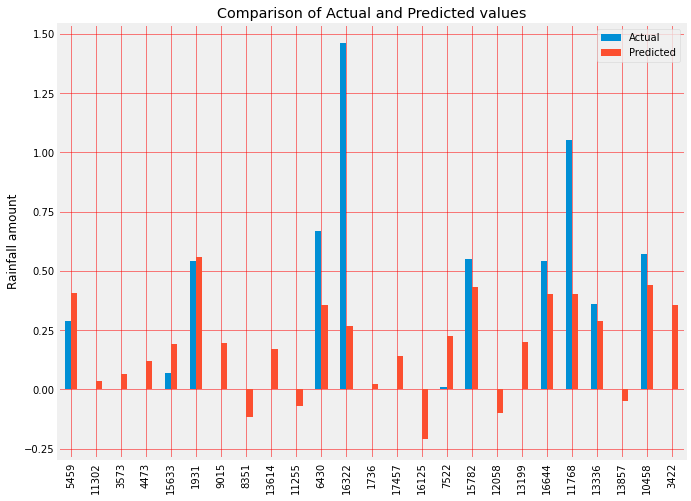

In [56]:
#plot camparison of Actual and Predicted values
dlf1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.ylabel('Rainfall amount')
plt.title('Comparison of Actual and Predicted values')
plt.show()

***Our prediction model is not very precise. The predicted percentages are close to the actual on a few occassions but far off on others***

In [57]:
y_train_pred = regressor.predict(X_train)


#print mean absolute error, mean square error and root mean squared error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score: %.2f' % r2_score(y_test,y_pred))
print('Train R2 score: %.2f' % r2_score(y_train_pred, y_train))

lr_train_rsq= r2_score(y_train_pred, y_train)
lr_rsq= r2_score(y_test,y_pred)
lr_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 0.22367748940506246
Mean Squared Error: 0.17876735392009277
Root Mean Squared Error: 0.4228088858102355
R2 score: 0.22
Train R2 score: -2.55


***Root mean square error is 0.38 which is higher than the Rainfall mean value.***


***There are many factors that could contribute to our inaccuracy. We could use more data features to see if there are any other factors that have a more positive co-efficiency with predicting rainfall.***

## XGBoost

In [162]:
#using the same dataset as with our other models
#Rainfall(in) is our prediction feature
X = df_lr[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_lr['Rainfall(in)']

In [163]:
#split 80% of our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

model = xgboost.XGBRegressor(objective ='reg:squarederror', max_depth = 10, learning_rate = 0.05) 

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [60]:
#tuning parameters
parameters_for_testing = {
    'min_child_weight':[1,2,3],
    'learning_rate':[0.1,0.07,0.05],
    'max_depth':[3,5],
}

                    
xgb_model = xgboost.XGBRegressor(objective = 'reg:squarederror', learning_rate =0.1, n_estimators=1000, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=15)

gsearch1 = GridSearchCV(cv = 5, estimator = xgb_model, param_grid = parameters_for_testing, 
                        n_jobs=6,iid=False, verbose=10,scoring='r2')
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   52.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   52.5s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  7.7min finished
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=1,
                                    seed=15, subsample=0.8, tree_method=None,
   

In [61]:
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

best params
{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3}
best score
0.2901346403618815


In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

model = xgboost.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                         colsample_bytree=1, max_depth=7, n_jobs=-1)

#fit our model
model.fit(X_train, y_train)

#predict our model
y_pred = model.predict(X_test)

In [165]:
xgb_feature_importances = pd.DataFrame({'feature': X.columns,
                                        'importance': model.feature_importances_}).sort_values('importance',
                                                                                               ascending=False)
xgb_feature_importances.head(10)

feature  importance
6        Wind_speed(mph)    0.225984
1            Humidity(%)    0.224297
4           Min_temp(°F)    0.132090
5       Average_temp(°F)    0.129403
3           Max_temp(°F)    0.105768
2  Sealevel_pressure(Hg)    0.099890
0      Dewpoint_temp(°F)    0.082569

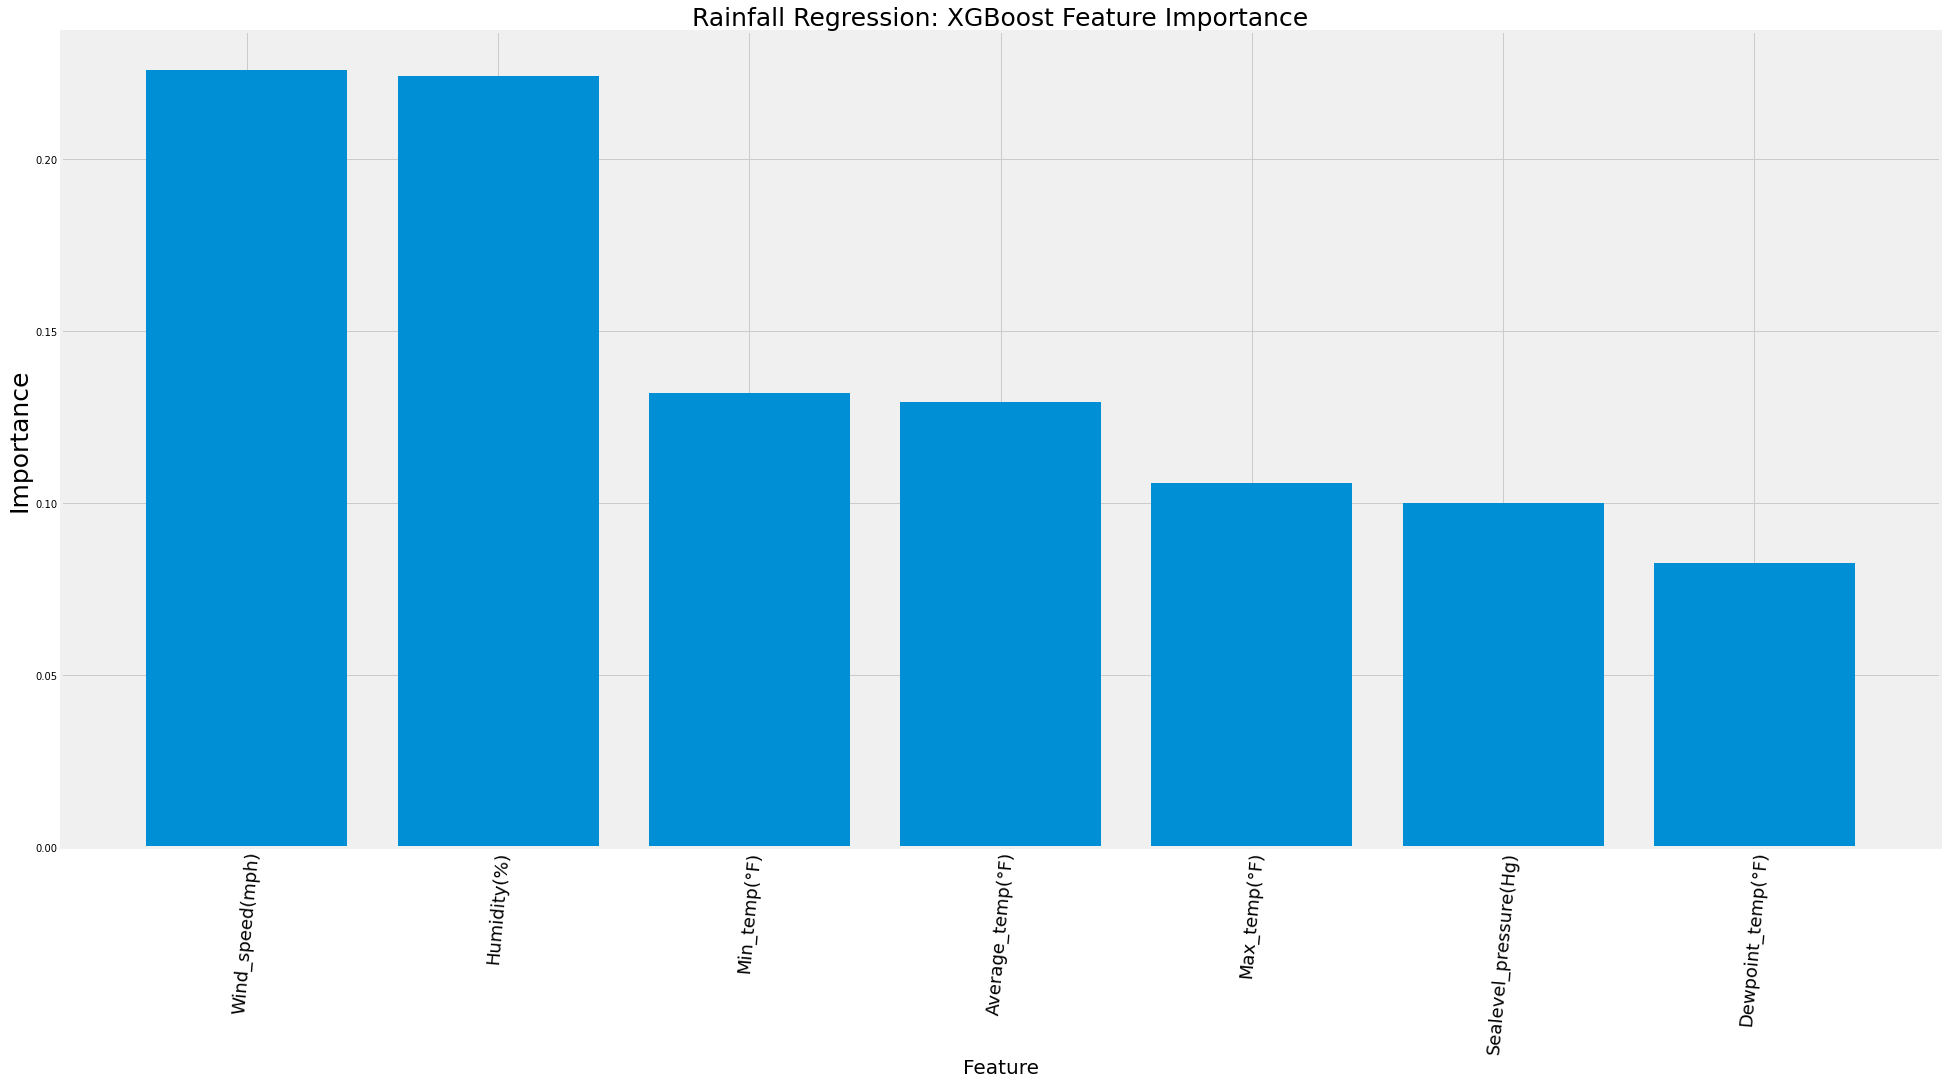

In [166]:
plt.bar(xgb_feature_importances.feature, xgb_feature_importances.importance)
plt.xlabel('Feature', fontsize=20)
plt.ylabel('Importance', fontsize= 25)
plt.xticks(xgb_feature_importances.feature[:10], rotation = 85, fontsize=18)
plt.title('Rainfall Regression: XGBoost Feature Importance', fontsize=25)
plt.show()

***We see that Humidity and Windspeed have the highest importance amongst our values. Average temperature and Sealevel pressure have nearly half the importance. Dewpoint temperature being so low is surprising.***

In [167]:
#predict model
model.predict(X_test)

#model test score
xgb_test = model.score(X_test, y_test)
print('Test score:', xgb_rsq)

#model train score
xgb_train = model.score(X_train, y_train)
print('Train score:', xgb_rss)

Test score: 0.3230095498511284
Train score: 0.6963546348839369


In [66]:
#cross validataion 
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
 
ypred = model.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("Mean Squared Error: %.2f" % mse)
print("Root Mean Squared Error: %.2f" % np.sqrt(mse))

xgb_rmse= np.sqrt(mse)
xgb_rsq_test= r2_score(y_test,y_pred)
xgb_train_rsq_out= r2_score(y_train_pred, y_train)

Mean cross-validation score: 0.29
K-fold CV average score: 0.30
Mean Squared Error: 0.15
Root Mean Squared Error: 0.39


***Our test and training scores means our model isn't too overfit.***

***Our feature importance seem to keep in line with our other models and correlation heatmaps with rainfall. Humidity has usually been at or near the top. Dewpoint seems to be a bit lower than usual.***

***Our score is a bit low. We could add other outside features to see if it would increase our score.***

## Random Forest Regression

In [67]:
#using the same dataset as with our other models
#Rainfall(in) is our prediction feature
X = df_lr[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_lr['Rainfall(in)']

#split 70 of our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# create regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=23)

# fit the regressor with x and y data
rf.fit(X_train, y_train)

#predict our model
y_pred = rf.predict(X_test)

#test score of our model
rf_rsq = rf.score(X_test, y_test)

print('Model R-squared:', round(rf_rsq, 3))

Model R-squared: 0.303


In [198]:
X = df_lr[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_lr['Rainfall(in)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

tree = RandomForestRegressor(n_estimators=1000)

#fit our model
tree.fit(X_train, y_train)

#predict our model
y_pred = tree.predict(X_test)

#predict model
tree.predict(X_test)

#model test score
rf_test = tree.score(X_test, y_test)
print('Test score:', rf_test)

#model train score
rf_train = tree.score(X_train, y_train)
print('Train score:', rf_train)

Test score: 0.28911566010192435
Train score: 0.9043539053963886


In [68]:
rf_feat_df = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}
             ).sort_values('importance', ascending=False)
rf_feat_df['rank'] = range(1,len(rf_feat_df)+1)
rf_feat_df.head(10)

feature  importance  rank
1            Humidity(%)    0.282782     1
6        Wind_speed(mph)    0.217315     2
2  Sealevel_pressure(Hg)    0.151470     3
0      Dewpoint_temp(°F)    0.105038     4
3           Max_temp(°F)    0.090954     5
4           Min_temp(°F)    0.089354     6
5       Average_temp(°F)    0.063088     7

***The top of our features are in the same order as our previous importance list. Dewpoint temperature has moved up while our Max, Min, Average temperatures are at the bottom of importance***

In [69]:
clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_train, y_train)
print('Test score: ', clf.score(X_test, y_test))

Test score:  0.2915233108605293


In [70]:
print('Training Features Shape:', X_test.shape)
print('Training Labels Shape:', y_test.shape)
print('Testing Features Shape:', X_train.shape)
print('Testing Labels Shape:', y_train.shape)

Training Features Shape: (3645, 7)
Training Labels Shape: (3645,)
Testing Features Shape: (14580, 7)
Testing Labels Shape: (14580,)


In [71]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [72]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.17 degrees.


***Our average estimate is off by 0.17 degrees which is under the baseline.***

In [73]:
#create list of X columns
feature_list = list(X.columns)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Humidity(%)          Importance: 0.28
Variable: Wind_speed(mph)      Importance: 0.22
Variable: Sealevel_pressure(Hg) Importance: 0.15
Variable: Dewpoint_temp(°F)    Importance: 0.1
Variable: Max_temp(°F)         Importance: 0.09
Variable: Min_temp(°F)         Importance: 0.09
Variable: Average_temp(°F)     Importance: 0.06


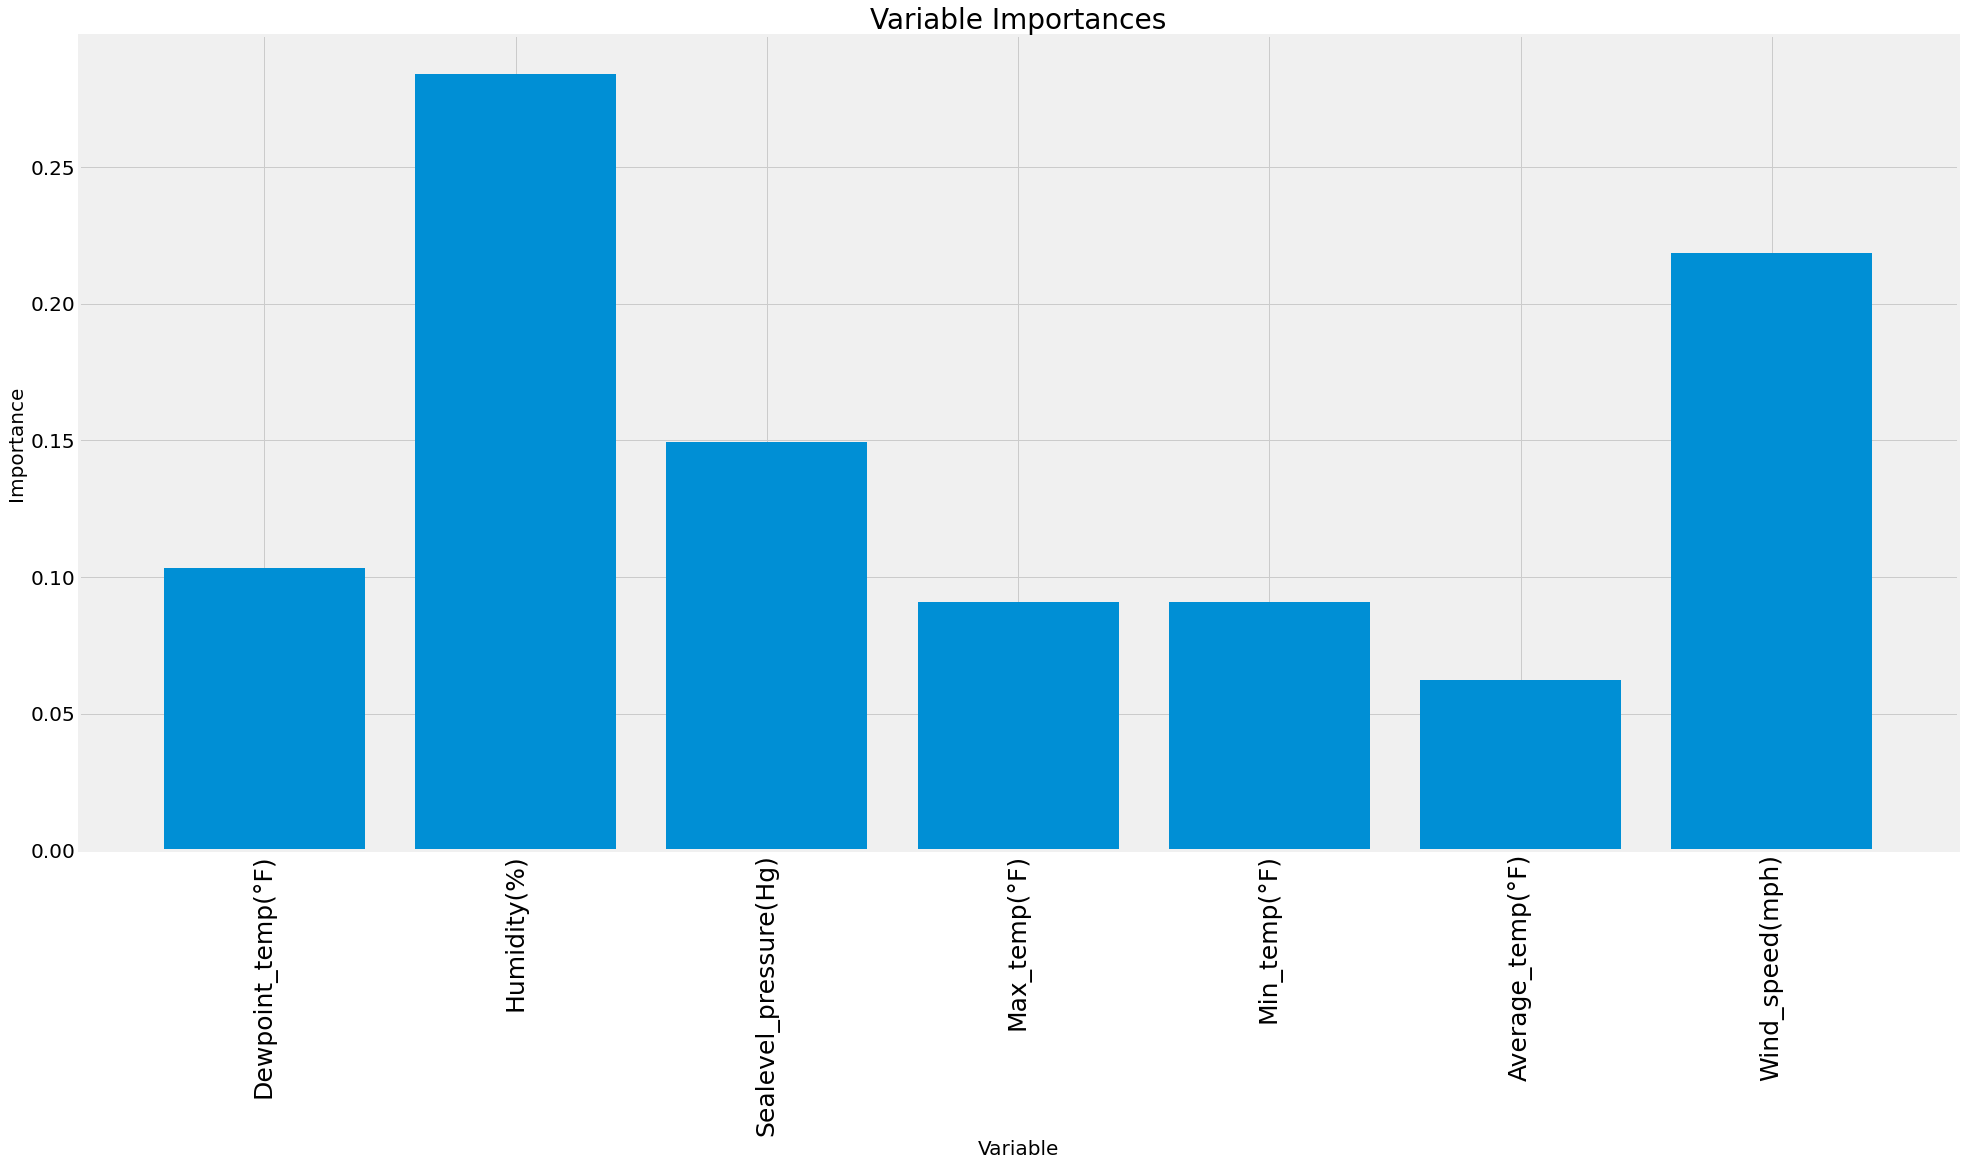

In [74]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical', fontsize= 25)

# Axis labels and title
plt.ylabel('Importance', fontsize=20)
plt.xlabel('Variable', fontsize=20)
plt.yticks(fontsize=20)
plt.title('Variable Importances', fontsize=28);

***Bar plot of the feature importances to show the disparities in the relative significance of the variables. As mentioned before Humidity and Windspeed show the highest importance levels***

In [75]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [76]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [77]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

rf_rsq_test= r2_score(y_test,y_pred)
rf_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 0.1710509373571102
Mean Squared Error: 0.16378150940405425
Root Mean Squared Error: 0.40469928268290056


# Models with outliers included

In our previous models we took out the outliers in our Rainfall value. We'll rerun the models with the outliers included to see if there's any sort of substantial difference between the models

### Create the input data for Prophet (Rainfall w/ outliers)

We'll be using our dataset that we already cleaned in our data wrangling section. Unlike our previous models, we'll be leaving our outliers in our dataset. We still need to manipulate it a bit to work with Prophet.

In [78]:
#prepare our dataset for Prophet timeseries
df = df_read.copy()

#Convert string datetime into readable datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

#create dataframe with columns that we'll be using
df = df[['datetime','Dewpoint_temp(°F)','Humidity(%)','Sealevel_pressure(Hg)','Max_temp(°F)','Min_temp(°F)',
           'Average_temp(°F)', 'Wind_speed(mph)','Rainfall(in)']]

#set index to datetime
df.set_index('datetime', inplace=True)

print(df.shape)

(18243, 8)


In [79]:
#create input features and target variable
#drop feature
X= df.drop('Rainfall(in)', axis=1)

#include features
y= df['Rainfall(in)']

In [80]:
#importances of our values in correlation to their impact on rainfall
importances= X.apply(lambda x: x.corr(y))
indices= np.argsort(importances)
print(importances[indices])

Sealevel_pressure(Hg)   -0.194946
Max_temp(°F)             0.005526
Average_temp(°F)         0.060142
Min_temp(°F)             0.104485
Dewpoint_temp(°F)        0.150118
Humidity(%)              0.311427
Wind_speed(mph)          0.321254
dtype: float64


***As we can see, wind speed and humidity have the biggest correlation with rainfall.***

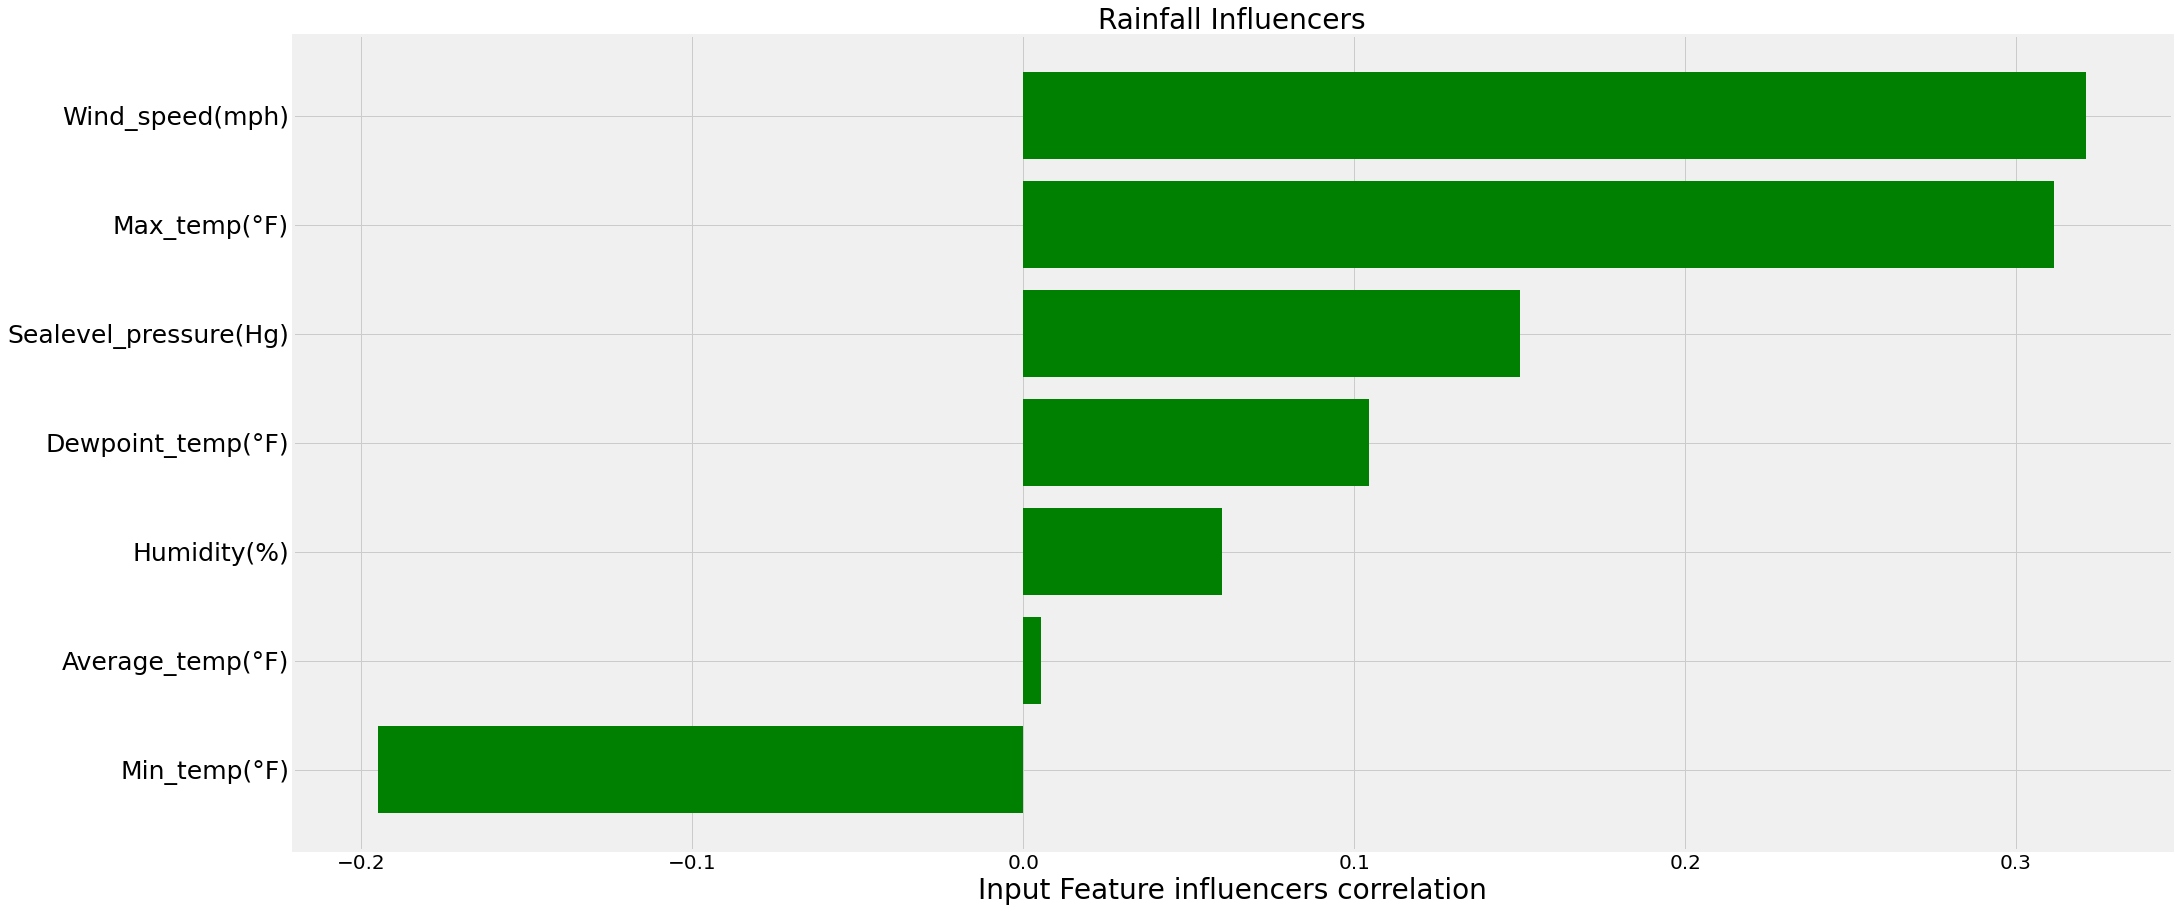

In [81]:
names=['Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
       'Dewpoint_temp(°F)', 'Humidity(%)', 'Wind_speed(mph)', 'type']
plt.title('Rainfall Influencers', fontsize=28)
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [names[i] for i in indices], fontsize=25)
plt.xticks(fontsize=20)
plt.xlabel('Input Feature influencers correlation', fontsize=28)
plt.show()

In [82]:
#create dataframe off original dataset, remove outliers
df1 = df_read.copy()

#create input features and target variable from dataset with datetime
#drop feature
X= df1.drop('Rainfall(in)', axis=1)

#include features
y= df1['Rainfall(in)']

In [83]:
#create dataframe with ds(datestamp) and y(predicted numeric column)
train_dataset= pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(X["datetime"])
train_dataset['y']=y
train_dataset.head(2)

ds    y
0 2010-01-01  0.0
1 2010-01-02  0.0

In [84]:
#create and fit model with default values
# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet_basic = Prophet(interval_width=0.95)

#fit model
prophet_basic.fit(train_dataset)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [85]:
#predict values for the future
future= prophet_basic.make_future_dataframe(periods=731)
future.tail(5)

ds
18969 2021-12-27
18970 2021-12-28
18971 2021-12-29
18972 2021-12-30
18973 2021-12-31

***We set our future at 2 years(730 days) past our original dataset. Our future contains 18973 and will predict into the future (2021-12-31)***

In [86]:
#create forecast of future
forecast=prophet_basic.predict(future)

Text(0.5, 1.0, 'Rainfall(in)')

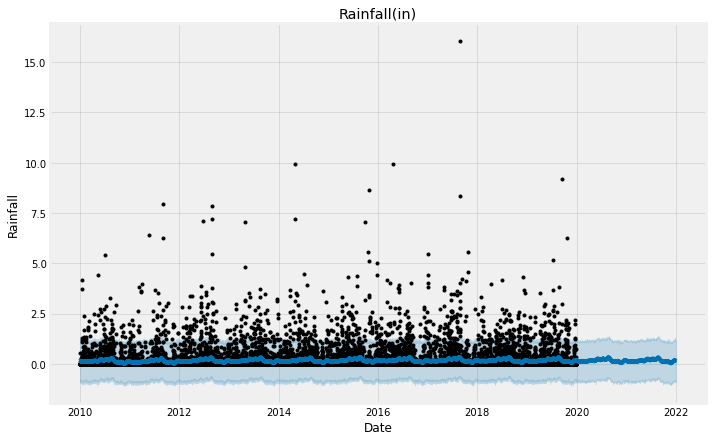

In [87]:
#plot predicted data
fig1 =prophet_basic.plot(forecast, xlabel='Date', ylabel='Rainfall')
plt.title('Rainfall(in)')

***The blue lines represent the forecasted values and the uncertainty intervals of the forecasts are the blue shaded regions.***

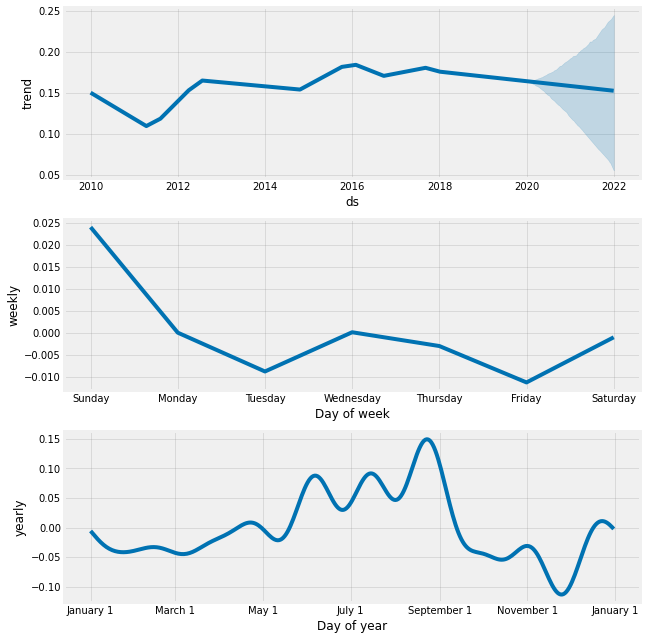

In [88]:
#plot the forecasted components
fig2 = prophet_basic.plot_components(forecast)

***The first plot shows that the monthly volume of rainfall dropped in 2011 but steadily increased until 2016 when it started to decrease slightly each year.***

***The second plot shows a mostly decrease in weekly trends. Day of the week isn't commonly a factor in weather though.***

***Our final plot is interesting because traditionally weather is affected by seasonal habits. As we can see in our plot, the warmer months of May-September were higher than the rest of the year but there were dips within those months.***

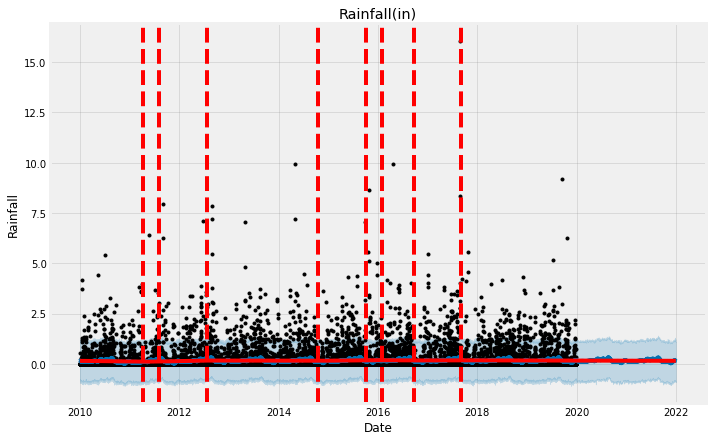

In [89]:
#Prophet detects changepoints by first specifying a large number of potential ChangePoints at which the rate is allowed to change
fig = prophet_basic.plot(forecast, xlabel='Date', ylabel='Rainfall')
plt.title('Rainfall(in)')
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

In [90]:
#view the dates where the ChangePoints occurred
prophet_basic.changepoints

584     2010-04-27
1167    2010-08-22
1751    2010-12-17
2335    2011-04-13
2919    2011-08-07
3502    2011-12-02
4086    2012-03-29
4670    2012-07-24
5253    2012-11-17
5837    2013-03-14
6421    2013-07-09
7005    2013-11-03
7588    2014-03-01
8172    2014-06-25
8756    2014-10-20
9340    2015-02-15
9923    2015-06-12
10507   2015-10-06
11091   2016-01-31
11674   2016-05-27
12258   2016-09-21
12842   2017-01-15
13426   2017-05-12
14009   2017-09-06
14593   2018-01-01
Name: ds, dtype: datetime64[ns]

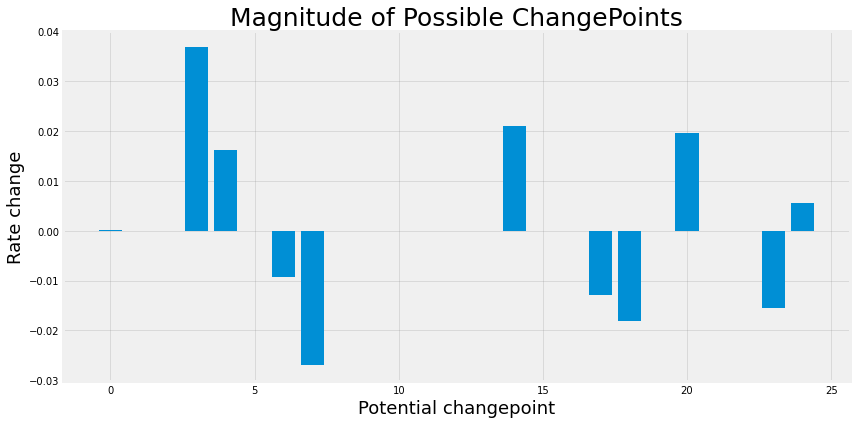

In [91]:
#look at the magnitudes of these possible changepoints
deltas = prophet_basic.params['delta'].mean(0)
fig = plt.figure(figsize=(12,6),facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_title('Magnitude of Possible ChangePoints', fontsize=25)
ax.set_ylabel('Rate change', fontsize=18)
ax.set_xlabel('Potential changepoint', fontsize=18)
fig.tight_layout()

### Ajusting Trend

By default the scale is set to 0.05 so we'll adjust the trend to be more flexible by increasing the value and then by decreasing the value.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


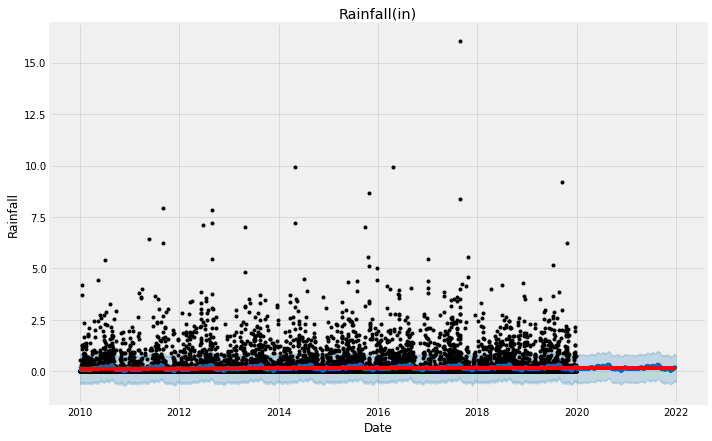

In [92]:
#decrease the ChangePoint prior scale
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.02)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast, xlabel='Date', ylabel='Rainfall')
plt.title('Rainfall(in)');
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


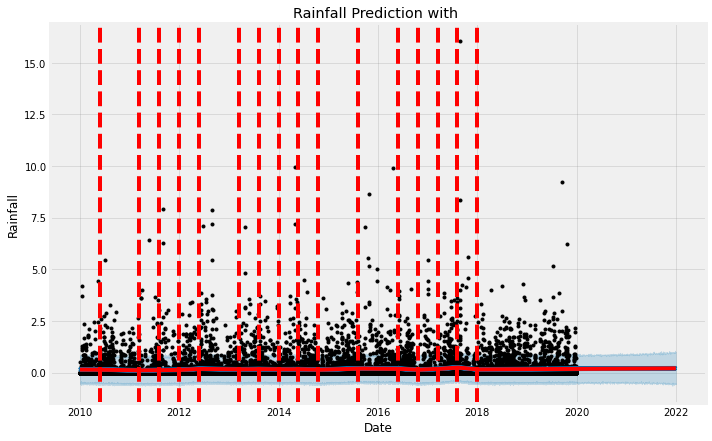

In [93]:
#increase the ChangePoint prior scale
pro_change= Prophet(n_changepoints=20, yearly_seasonality=False, changepoint_prior_scale=0.08)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast, xlabel='Date', ylabel='Rainfall')
plt.title('Rainfall Prediction with ');
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [94]:
#view the dates where the ChangePoints occurred
pro_change.changepoints

730     2010-05-27
1459    2010-10-19
2189    2011-03-14
2919    2011-08-07
3648    2012-01-01
4378    2012-05-26
5108    2012-10-19
5837    2013-03-14
6567    2013-08-07
7296    2014-01-01
8026    2014-05-27
8756    2014-10-20
9485    2015-03-16
10215   2015-08-09
10945   2016-01-02
11674   2016-05-27
12404   2016-10-20
13134   2017-03-15
13863   2017-08-08
14593   2018-01-01
Name: ds, dtype: datetime64[ns]

***Our graphs did a good job of predicting a base amount of rainfall for the next 2 years. We can fine tune it a bit more to get more precise blue lines and blue shaded area.***

In [95]:
#looking at hurricane season factored in
#Hurricane season (06-01 to 11-30)
hurricane_season = pd.DataFrame({'holiday': "hurricane season",
                      'ds' : pd.to_datetime(['2010-06-01','2011-06-01','2012-06-01','2013-06-01',
                                            '2014-06-01','2015-06-01','2016-06-01','2017-06-01',
                                            '2018-06-01','2019-06-01']),
                      'lower_window': 0,
                      'upper_window': 162})

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


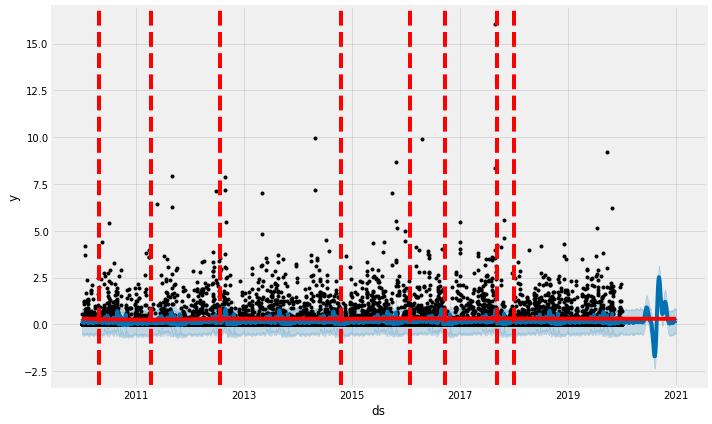

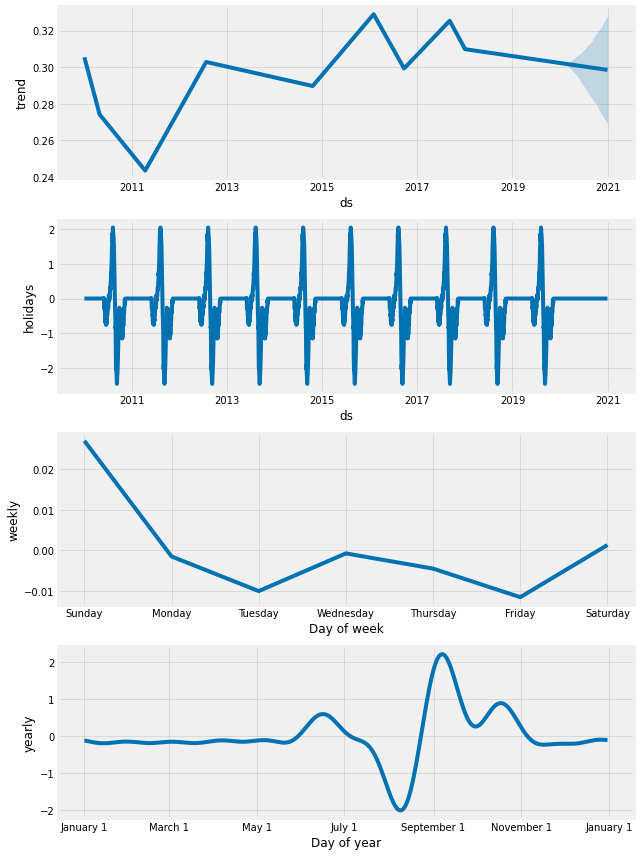

In [96]:
prophet = Prophet(holidays=hurricane_season)
prophet.fit(train_dataset)
future = prophet.make_future_dataframe(periods=365, freq='D')

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

***Looking at the yearly graph, we can see that there was a dip by late July into mid August but then the peak was early September. The trend graph shows an early dip but that it raised over the last few years of the decade.***

In [97]:
#cross validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(prophet_basic, initial='730 days', period='90 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 29 forecasts with cutoffs between 2012-02-06 00:00:00 and 2018-12-31 00:00:00


ds      yhat  yhat_lower  yhat_upper     y     cutoff
0 2012-02-07  0.113578   -0.863661    0.991657  0.00 2012-02-06
1 2012-02-07  0.113578   -0.699967    0.933196  0.06 2012-02-06
2 2012-02-07  0.113578   -0.760016    1.009252  0.00 2012-02-06
3 2012-02-07  0.113578   -0.725826    0.947360  0.00 2012-02-06
4 2012-02-07  0.113578   -0.727351    1.027646  0.00 2012-02-06

In [98]:
# Python
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


horizon       mse      rmse       mae  mdape  coverage
0 37 days  0.316871  0.562913  0.263325    inf  0.955672
1 38 days  0.315465  0.561663  0.262647    inf  0.955973
2 39 days  0.289953  0.538472  0.259836    inf  0.956653
3 40 days  0.268476  0.518146  0.257905    inf  0.957285
4 41 days  0.269588  0.519218  0.259444    inf  0.956629

In [99]:
#create y_true and y_pred
y_true= df_cv.y
y_pred= df_cv.yhat

print('Mean square error: ', mean_squared_error(y_true, y_pred))
print('Mean absolute error: ', mean_absolute_error(y_true, y_pred))
print('Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))


ph_rmse_out = np.sqrt(metrics.mean_squared_error(y_true, y_pred))

Mean square error:  0.2953994489761728
Mean absolute error:  0.26067304115874984
Root Mean Squared Error:  0.5435066227528169


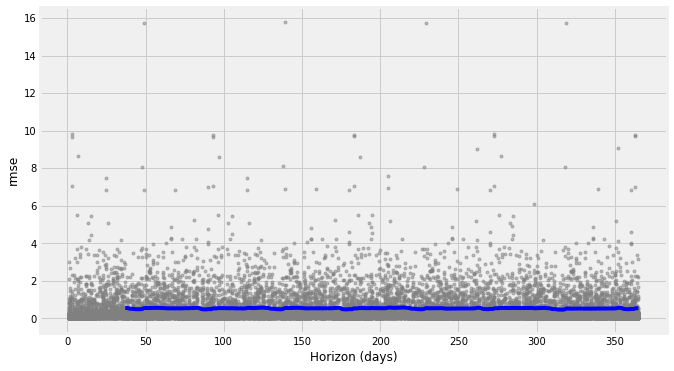

In [100]:
# Python
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

***Our MSE and MAE are higher than our model without our rainfall outliers. RMSE is higher as well***

## Simple Linear Regression

In [101]:
#create our dataframe for Linear Regression starting with our cleaned dataset
df_out = df_read.copy()

In [102]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18243 entries, 0 to 18242
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   18243 non-null  object 
 1   datetime               18243 non-null  object 
 2   Dewpoint_temp(°F)      18243 non-null  float64
 3   Humidity(%)            18243 non-null  float64
 4   Sealevel_pressure(Hg)  18243 non-null  float64
 5   Max_temp(°F)           18243 non-null  float64
 6   Min_temp(°F)           18243 non-null  float64
 7   Average_temp(°F)       18243 non-null  float64
 8   Wind_speed(mph)        18243 non-null  float64
 9   Rainfall(in)           18243 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.4+ MB


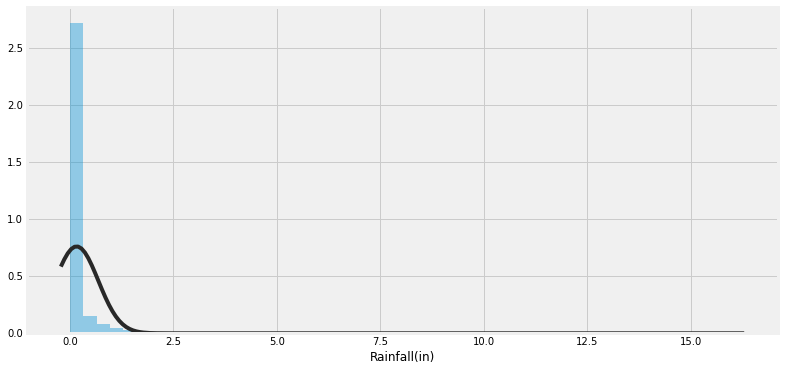

In [103]:
#plot our Rainfall value
plt.figure(figsize=(12,6))
plt.tight_layout()
seabornInstance.distplot(df_out['Rainfall(in)'],fit=norm, kde=False)

***We can see that a majority of our days consisted of zero rainfall with amounts under 1" having a strong showing as well. Average looks to be around 0.01-0.02 inches***

In [104]:
#divide dataframe into independent variables(X) and dependent variables(y)
X = df_out['Humidity(%)'].values.reshape(-1,1)
y = df_out['Rainfall(in)'].values.reshape(-1,1)

In [105]:
#split 80% of our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [106]:
#train our algorithm
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [107]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[-0.89758329]
[[0.01435188]]


***We can see that for every one unit of change in Dewpoint temps, there is a minimal change in Rainfall.***

In [108]:
#make predictions with our test data
y_pred = regressor.predict(X_test)

In [109]:
#compare the actual output values with the predicted values
dl = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
dl

Actual  Predicted
0       0.00   0.150104
1       0.01   0.150104
2       0.00   0.136742
3       0.00   0.078345
4       0.00   0.254031
...      ...        ...
3644    0.67   0.193160
3645    0.00   0.250567
3646    0.00   0.049641
3647    0.00  -0.022119
3648    0.27   0.150104

[3649 rows x 2 columns]

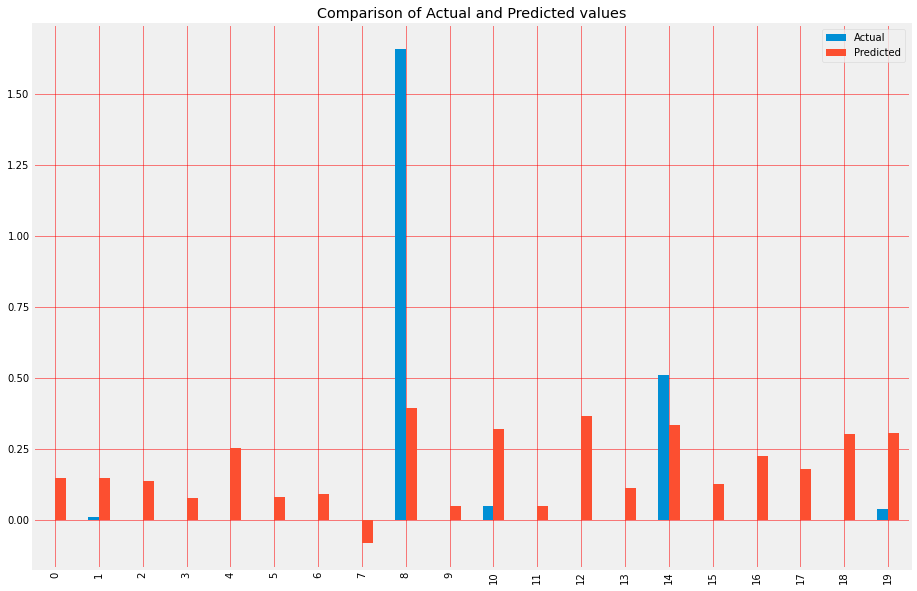

In [110]:
#we'll take a look at the 1st 20 records
dl1 = dl.head(20)
dl1.plot(kind='bar',figsize=(14,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Comparison of Actual and Predicted values')
plt.show()

***We can see that our predicted precentages aren't close to our actual ones***

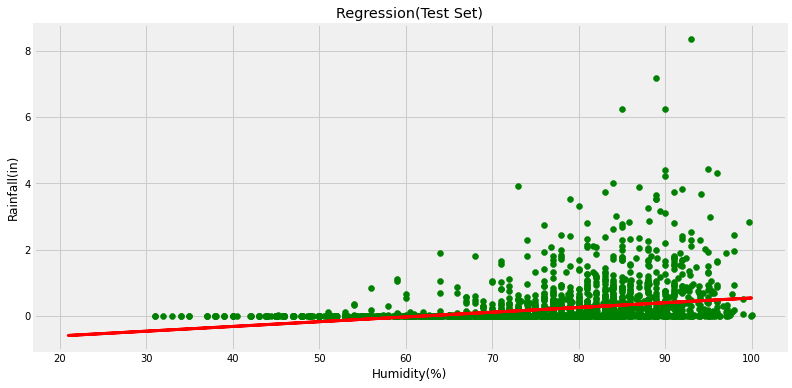

In [111]:
#plot straight line with the test data
plt.figure(figsize=(12,6))
plt.scatter(X_test,y_test,color="green") # Plot a graph with X_test vs y_test
plt.plot(X_train,regressor.predict(X_train),color="red",linewidth=3) # Regressior line showing
plt.title('Regression(Test Set)')
plt.xlabel('Humidity(%)')
plt.ylabel('Rainfall(in)')
plt.show()

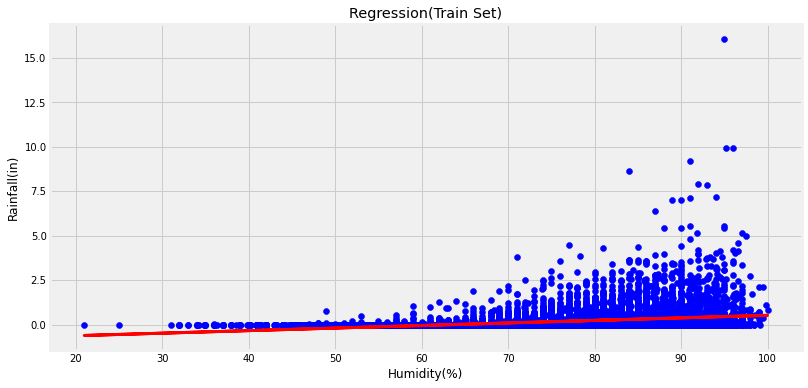

In [112]:
#plot straight line with the train data
plt.figure(figsize=(12,6))
plt.scatter(X_train,y_train,color="blue")  # Plot a graph with X_train vs y_train
plt.plot(X_train,regressor.predict(X_train),color="red",linewidth=3) # Regressior line showing
plt.title('Regression(Train Set)')
plt.xlabel('Humidity(%)')
plt.ylabel('Rainfall(in)')
plt.show()

In [113]:
#print mean absolute error, mean square error and root mean squared error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score: %.2f' % r2_score(y_test,y_pred))

Mean Absolute Error: 0.24838378826197569
Mean Squared Error: 0.24144176356370262
Root Mean Squared Error: 0.4913672390012409
R2 score: 0.10


***We can see that the value of the root mean squared error is 0.4269 which is more than 10% of the mean value of 73.605187. It can be better but still can make good predictions.***

## Multiple Linear Regression

In the last section we used a simple linear regression that left off most of our dataset. Here we'll included the other variables and hopefully get better results.

In [114]:
#we'll use the same dataframe as before
df_out.describe()

Dewpoint_temp(°F)   Humidity(%)  Sealevel_pressure(Hg)  Max_temp(°F)  \
count       18243.000000  18243.000000           18243.000000  18243.000000   
mean           60.499926     73.628929              30.049150     79.980266   
std            13.934829     11.397478               0.140398     12.198700   
min             4.708333     21.000000              29.440000     31.000000   
25%            52.000000     67.000000              29.960000     72.000000   
50%            64.500000     75.000000              30.035833     82.000000   
75%            72.000000     82.000000              30.130000     90.000000   
max            80.000000    100.000000              30.695417    109.000000   

       Min_temp(°F)  Average_temp(°F)  Wind_speed(mph)  Rainfall(in)  
count  18243.000000      18243.000000     18243.000000  18243.000000  
mean      61.407170         70.944581        22.768459      0.159897  
std       14.031359         12.746689         6.947135      0.523273  
min       16.000000         26.000000         0.000000      0.000000  
25%       51.000000         62.000000        18.000000      0.000000  
50%       65.000000         74.000000        22.000000      0.000000  
75%       74.000000         82.000000        26.000000      0.030000  
max       85.000000         95.000000       120.000000     16.070000

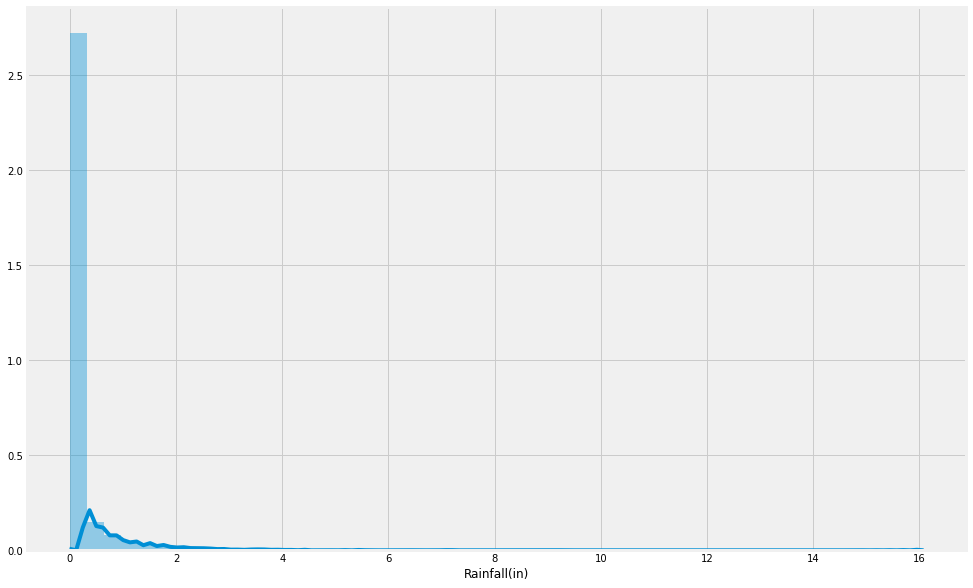

In [115]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(df_out['Rainfall(in)'])

In [147]:
#divide dataframe into independent variables(X) and dependent variables(y)
X = df_out[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_out['Rainfall(in)']

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

#train our model
regressor = LinearRegression()

#fit our model
regressor.fit(X_train, y_train)

#predict our test model
y_pred = regressor.predict(X_test)

#predict our training model
y_pred1 = regressor.predict(X_train)

In [149]:
#model test score
lr_test_out = regressor.score(X_test, y_test)
print('Test score:  %.3f' % xgb_rsq)

#model train score
lr_train_out = regressor.score(X_train, y_train)
print('Train score:  %.3f'% xgb_rss)

#train RMSE
print('Train RMSE: %.3f' % train_rmse)

#test RMSE
print('Test RMSE: %.3f' % test_rmse)

Test score:  0.323
Train score:  0.696
Train RMSE: 0.398
Test RMSE: 0.423


In [150]:
#train our model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [151]:
#create dataframe of our features and their importances to dependent varaible(Rainfall)
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  

coeff_df

Coefficient
Dewpoint_temp(°F)        -0.019476
Humidity(%)               0.020152
Sealevel_pressure(Hg)    -0.228957
Max_temp(°F)              0.006074
Min_temp(°F)              0.017008
Average_temp(°F)         -0.006568
Wind_speed(mph)           0.022094

***For a unit incrase in Dewpoint temps, there is a decrease of -0.017 of Rainfall. A unit of decrease in Sealevel Pressure results a decrease of -0.22***

In [152]:
#predict test data
y_pred = regressor.predict(X_test)

In [153]:
#difference between actual value and predicted value
dlf = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
dlf1 = dlf.head(25)
dlf1

Actual  Predicted
9336     0.00   0.123703
7267     0.00  -0.039213
9885     0.00   0.107204
16277    0.43   0.264623
13247    0.00   0.010790
1236     0.08   0.264421
1138     0.00   0.175265
10784    0.00  -0.023462
14685    0.00  -0.041331
16377    0.00  -0.170279
630      0.00  -0.133858
15224    0.01   0.119333
10810    0.01   0.321629
15223    2.16   0.304517
14659    0.00  -0.167096
10993    0.00  -0.119459
5180     1.96   0.808943
12177    0.00   0.102803
16305    0.00   0.124496
1618     0.50   0.392550
8668     0.19   0.496637
3771     0.95   0.472292
10582    1.31   0.689285
12842    0.00  -0.054354
6511     0.00   0.289866

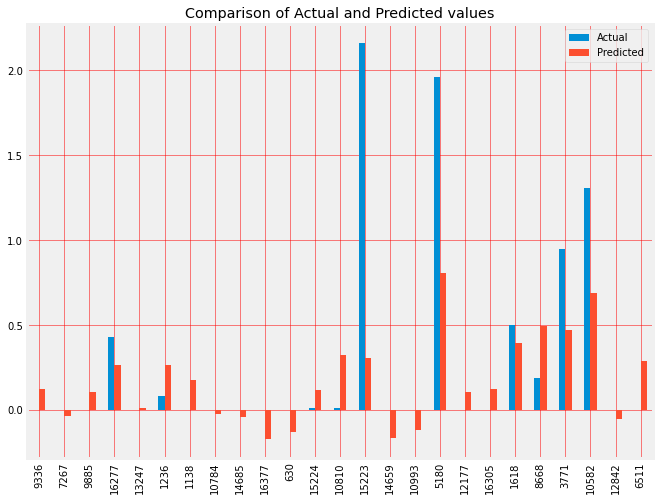

In [154]:
#plot camparison of Actual and Predicted values
dlf1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title('Comparison of Actual and Predicted values')
plt.show()

***Our prediction model is not very precise. The predicted percentages are close to the actual on a few occassions but far off on others***

In [155]:
y_train_pred = regressor.predict(X_train)

#print mean absolute error, mean square error and root mean squared error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score: %.2f' % r2_score(y_test,y_pred))
print('Train R2 score: %.2f' % r2_score(y_train_pred, y_train))

#lr_train_rsq_out= r2_score(y_train_pred, y_train)
lr_rsq_out= r2_score(y_test,y_pred)
lr_rsme_out = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 0.2348102012291876
Mean Squared Error: 0.2609202858600729
Root Mean Squared Error: 0.510803568762076
R2 score: 0.17
Train R2 score: -2.73


***Root mean square error is 0.40 which is higher than the Rainfall mean value.***


***There are many factors that could contribute to our inaccuracy. We could use more data features to see if there are any other factors that have a more positive co-efficiency with predicting rainfall.***

## XGBoost

In [126]:
import xgboost

# drop inconsequential features
X = df_out[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_out['Rainfall(in)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

model = xgboost.XGBRegressor(objective ='reg:squarederror', max_depth = 3, learning_rate = 0.05) 
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [127]:
#
parameters_for_testing = {
    'min_child_weight':[1,2,3],
    'learning_rate':[0.1,0.07,0.05],
    'max_depth':[3,5],
}

                    
xgb_model = xgboost.XGBRegressor(objective = 'reg:squarederror', learning_rate =0.1, n_estimators=1000, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=15)

gsearch1 = GridSearchCV(cv = 5, estimator = xgb_model, param_grid = parameters_for_testing, 
                        n_jobs=6,iid=False, verbose=10,scoring='r2')
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   45.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   46.2s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  5.2min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  7.4min finished
C:\Users\Jimsyd\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=1000, n...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=1,
                                    seed=15, subsample=0.8, tree_method=None,
   

In [128]:
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

best params
{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2}
best score
0.29578139320657465


In [129]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23)

model = xgboost.XGBRegressor(objective='reg:squarederror',
                             max_depth=5, learning_rate=0.05, min_child_weight=2)

#fit our model
model.fit(X_train, y_train)

#predict our model
y_pred = rf.predict(X_test)

#predict model
model.predict(X_test)

#model test score
xgb_test_out = model.score(X_test, y_test)
print('Test score:', xgb_rsq)

#model train score
xgb_train_out= model.score(X_train, y_train)
print('Train score:', xgb_rss)

Test score: 0.3230095498511284
Train score: 0.6963546348839369


In [130]:
xgb_feature_importances = pd.DataFrame({'feature': X.columns,
                                        'importance': model.feature_importances_}).sort_values('importance',
                                                                                               ascending=False)
xgb_feature_importances.head(10)

feature  importance
1            Humidity(%)    0.267714
6        Wind_speed(mph)    0.234796
4           Min_temp(°F)    0.121868
2  Sealevel_pressure(Hg)    0.100819
0      Dewpoint_temp(°F)    0.100753
5       Average_temp(°F)    0.097296
3           Max_temp(°F)    0.076754

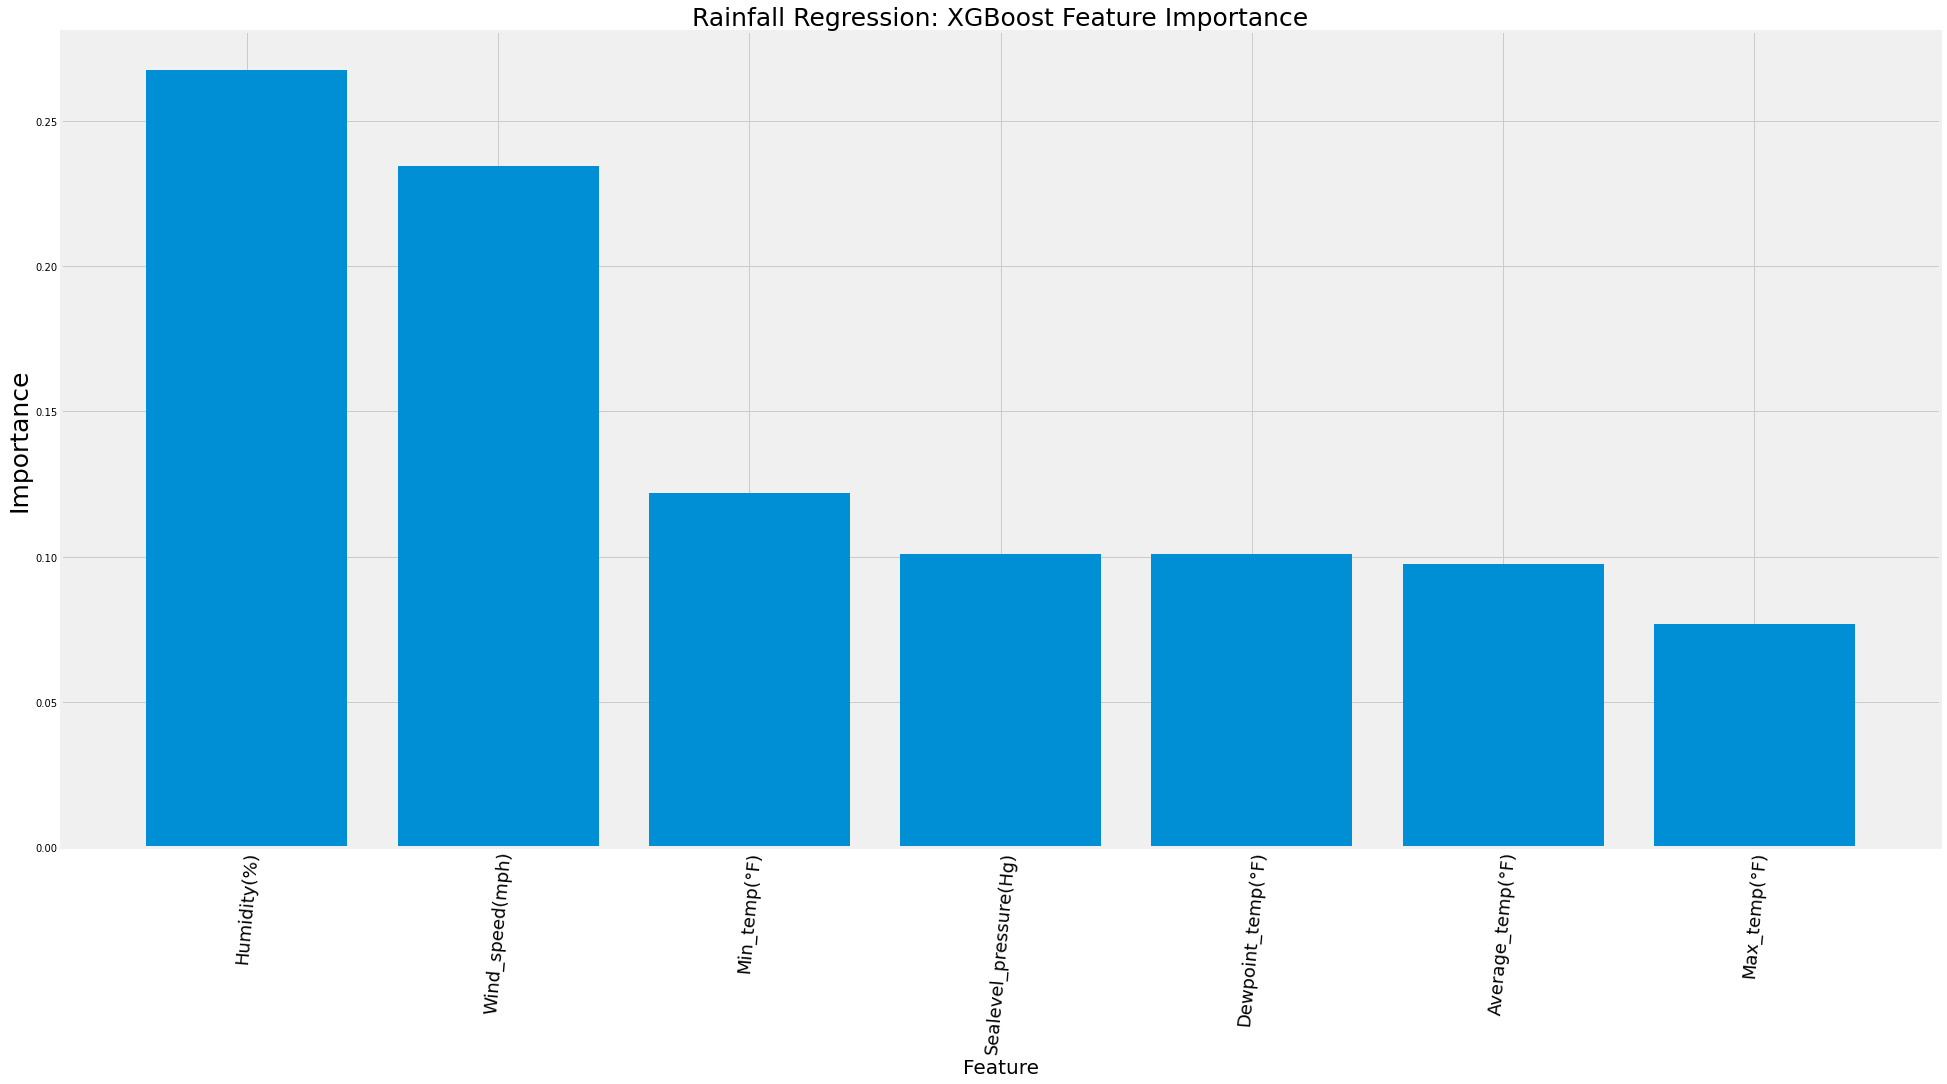

In [131]:
plt.bar(xgb_feature_importances.feature[:10], xgb_feature_importances.importance[:10])
plt.xlabel('Feature', fontsize=20)
plt.ylabel('Importance', fontsize= 25)
plt.xticks(xgb_feature_importances.feature[:10], rotation = 85, fontsize=18)
plt.title('Rainfall Regression: XGBoost Feature Importance', fontsize=25)
plt.show()

In [132]:
#cross validataion 
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
 
ypred = model.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

xgb_rsq_out= r2_score(y_test,y_pred)
xgb_rmse_out= np.sqrt(mse)

Mean cross-validation score: 0.31
K-fold CV average score: 0.32
MSE: 0.19
RMSE: 0.44


***Our test and training scores means our model isn't too overfit.***

***Our feature importance seem to keep in line with our other models and correlation heatmaps with rainfall. Humidity has usually been at or near the top. Dewpoint seems to be a bit lower than usual.***

***Our score is a bit low. We could add other outside features to see if it would increase our score.***

## Random Forest Regression

In [170]:
#using the same dataset as with our other models

# drop inconsequential features
X = df_out[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_out['Rainfall(in)']

#split 70 of our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# create regressor object
rf = RandomForestRegressor(n_estimators=100, random_state=23)

# fit the regressor with x and y data
rf.fit(X_train, y_train)

#predict our model
y_pred = rf.predict(X_test)

#Y_pred1=rf.predict(y_test)

#test score of our model
rf_rsq = r2_score(y_pred, y_test)



print('Model R-squared:', round(rf_rsq, 3))

Model R-squared: -0.506


In [197]:
X = df_out[['Dewpoint_temp(°F)', 'Humidity(%)', 'Sealevel_pressure(Hg)', 'Max_temp(°F)', 'Min_temp(°F)', 'Average_temp(°F)',
        'Wind_speed(mph)']]
y = df_out['Rainfall(in)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

trees = RandomForestRegressor(n_estimators=1000)

#fit our model
trees.fit(X_train, y_train)

#predict our model
y_pred = trees.predict(X_test)

#predict model
trees.predict(X_test)

#model test score
rf_test_out = trees.score(X_test, y_test)
print('Test score:', rf_test)

#model train score
rf_train_out = trees.score(X_train, y_train)
print('Train score:', rf_train)

Test score: 0.33372886086228026
Train score: 0.9078867983772859


In [134]:
rf_feat_df = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_}
             ).sort_values('importance', ascending=False)
rf_feat_df['rank'] = range(1,len(rf_feat_df)+1)
rf_feat_df.head(10)

feature  importance  rank
1            Humidity(%)    0.275984     1
6        Wind_speed(mph)    0.225668     2
2  Sealevel_pressure(Hg)    0.158980     3
0      Dewpoint_temp(°F)    0.099068     4
4           Min_temp(°F)    0.092702     5
3           Max_temp(°F)    0.086196     6
5       Average_temp(°F)    0.061401     7

***The order of our features are in the same order as before but their importance have dropped slightly***

In [135]:
clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.3319677446419629

In [136]:
print('Training Features Shape:', X_test.shape)
print('Training Labels Shape:', y_test.shape)
print('Testing Features Shape:', X_train.shape)
print('Testing Labels Shape:', y_train.shape)

Training Features Shape: (3649, 7)
Training Labels Shape: (3649,)
Testing Features Shape: (14594, 7)
Testing Labels Shape: (14594,)


In [137]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [138]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.18 degrees.


***Our average estimate is off by 0.17 degrees which is under the baseline.***

In [139]:
#create list of X columns
feature_list = list(X.columns)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Humidity(%)          Importance: 0.28
Variable: Wind_speed(mph)      Importance: 0.23
Variable: Sealevel_pressure(Hg) Importance: 0.16
Variable: Dewpoint_temp(°F)    Importance: 0.1
Variable: Min_temp(°F)         Importance: 0.09
Variable: Max_temp(°F)         Importance: 0.08
Variable: Average_temp(°F)     Importance: 0.06


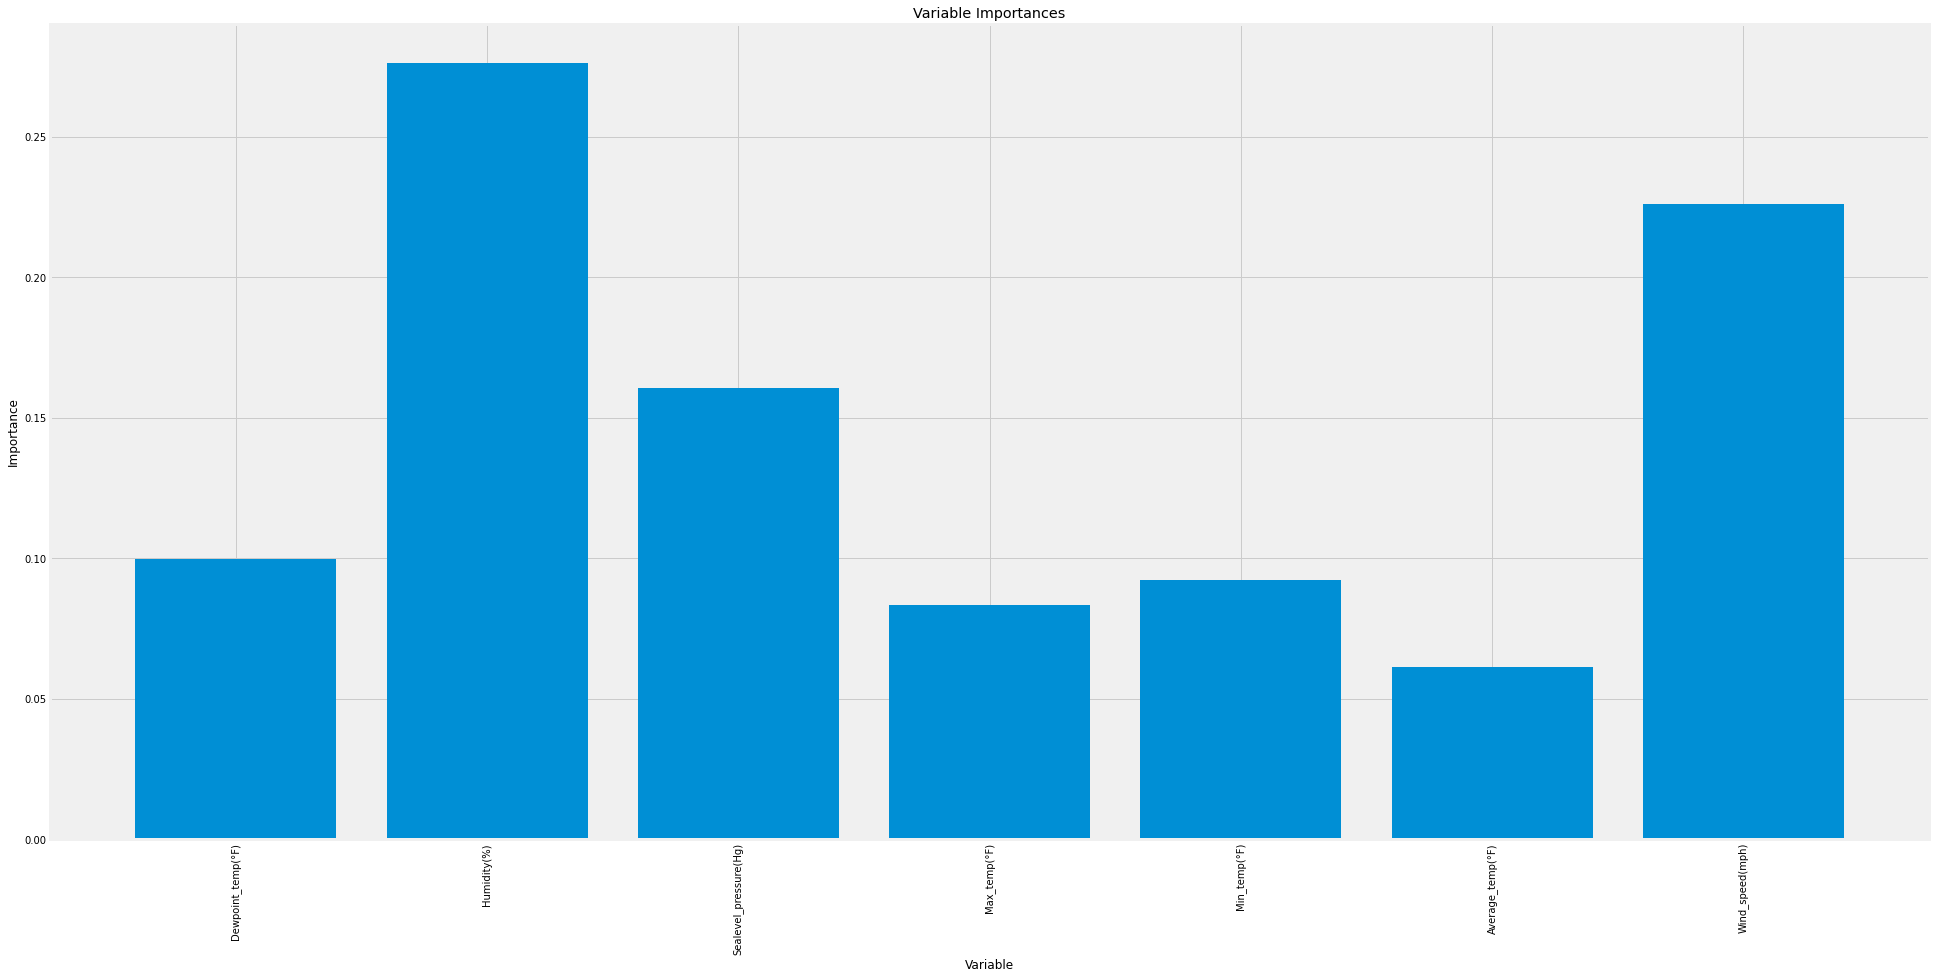

In [140]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

***Bar plot of the feature importances to show the disparities in the relative significance of the variables. As mentioned before Humidity and Windspeed show the highest importance levels***

In [141]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [142]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

#predict model
regressor.predict(X_test)

#model test score
rf_test = regressor.score(X_test, y_test)
print('Test score:', xgb_rsq)

#model train score
rf_train = regressor.score(X_train, y_train)
print('Train score:', xgb_rss)

In [143]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

rf_rsq_out= r2_score(y_test,y_pred)
rf_rmse_out= np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 0.18030880606558874
Mean Squared Error: 0.20986736824776955
Root Mean Squared Error: 0.45811283353314775


## Comparing Models

In [144]:
#create dataframe to compare models
regressor_models = pd.DataFrame({'name':['Linear Regression(multiple)','XGBoost','Random Forest'],
                                 'R-squared w/o Outliers':[lr_rsq,xgb_rsq,rf_rsq],
                                     'R-squared w/ Outliers':[lr_rsq_out,xgb_rsq_out,rf_rsq_out]
                                })
regressor_models

name  R-squared w/o Outliers  R-squared w/ Outliers
0  Linear Regression(multiple)                0.216363               0.174121
1                      XGBoost                0.323010               0.618901
2                Random Forest                0.336974               0.335717

In [156]:
#create dataframe to compare models
rmse_models = pd.DataFrame({'name':['Prophet','Linear Regression(multiple)','XGBoost','Random Forest'],
                                 'RMSE w/o Outliers':[ph_rmse,lr_rmse,xgb_rmse,rf_rmse],
                                     'RMSE w/ Outliers':[ph_rmse_out,lr_rsme_out,xgb_rmse_out,rf_rmse_out]
                                })
rmse_models

name  RMSE w/o Outliers  RMSE w/ Outliers
0                      Prophet           0.468276          0.543507
1  Linear Regression(multiple)           0.422809          0.510804
2                      XGBoost           0.392987          0.435941
3                Random Forest           0.404699          0.458113

In [199]:
#create dataframe to models test/training scores
model_test_train = pd.DataFrame({'name':['Linear Regression(multiple)','XGBoost','Random Forest'],
                                 'Test Score w/o Outliers':[lr_test,xgb_test,rf_test],
                                     'Training Score w/o Outliers':[lr_train,xgb_train,rf_train],
                                 'Test Score w/ Outliers':[lr_test_out,xgb_test_out,rf_test_out],
                                     'Training Score w/ Outliers':[lr_train_out,xgb_train_out,rf_train_out]
                                })
model_test_train

name  Test Score w/o Outliers  \
0  Linear Regression(multiple)                 0.216363   
1                      XGBoost                 0.323010   
2                Random Forest                 0.289116   

   Training Score w/o Outliers  Test Score w/ Outliers  \
0                     0.219623                0.174121   
1                     0.696355                0.398459   
2                     0.904354                0.338366   

   Training Score w/ Outliers  
0                    0.211589  
1                    0.540661  
2                    0.906897

## Conclusion

### Results summary:

XGBoost with outliers looked to be our best performing model. Considering how low our scores are, we have have to add in more features. We could add more cities into our dataset to see if more data points would help boost numbers.

To better predict weather for the Gulf Coast Area, looking at other parts of the world might be a good option. Considering weather that eventually affects certain regions, in our case the Gulf Coast area, we know that storms and weather patterns are influenced in other parts of the world 1st.

Our Root Mean Square Errors (RMSE) offers us a good low score. Our models are consistent amongst each other and their (with or without) outliers models. The models with outliers included have higher RMSE with Linear Regression(multiple) leading the way. Random Forest had the higher RMSE of the models without our outliers.

Our Prophet models showed some valuable future trends that can be usual for people and industries who rely on needing future rainfall predictions. For our project we casted a pretty wide Gulf Coast region so depending on who needed the prediction info, we could fine tune our models to be more city and/or smaller radius to a given area. Instead of being Houston all the way to Tampa we could focus only on Houston, Tampa or any of the other cities we chose for our project. More than likely a big storm hitting the New Orleans area would also affect people nearby in Mississippi and lower Alabama. Also depending on the size and direction of a storm, it could pass through all 5 of our cities in it's path.



# Scratch Notebook

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [ ]:
df = pd.read_csv('df_clean.csv')

In [ ]:
df1= df.copy()

In [ ]:
#Convert string DATE into readable datetime object
df1['datetime'] = pd.to_datetime(df1['datetime'])

In [ ]:
df1['datetime'].min(), df1['datetime'].max()

In [ ]:
df1.sort_values('Rainfall(in)')

In [ ]:
df1 = df1.set_index('datetime')
df1.index

In [ ]:
y1 = df1['Rainfall(in)'].resample('MS').mean()

In [ ]:
df1.drop('City', axis=1, inplace=True)
df1

In [ ]:
y1['2017':]

In [ ]:
y1.plot(figsize=(15,8))
plt.show()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y1, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y1,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima["2015-01-11":]

# Calculating the error
rms_arima = np.sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

# Compute the mean square error
#mse = ((y_forecasted - y_truth) ** 2).mean()
#print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
# Model Prediction
# Predictions are performed for the 11th Jan' 2015 onwards of the train data.
pred = results.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic = False)
# Get confidence intervals of forecasts
pred_ci = pred.conf_int()
ax = train_arima["2014":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
plt.legend
plt.show()
train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima["2015-01-11":]
# Calculating the error
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

In [ ]:
results

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y1['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Rainfall(in)')
plt.legend()

plt.show()

In [ ]:
df_lr["Rainfall(in)"] = np.log1p(df_lr["Rainfall(in)"])

#log transform skewed numeric features:
numeric_feats = df.dtypes[df.dtypes != "object"].index

skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

df[skewed_feats] = np.log1p(df[skewed_feats])

In [ ]:
df_lr = df_lr.copy()
df_lr.drop(['City', 'datetime'], axis=1, inplace=True)
X, y = df_lr.drop(['Rainfall(in)'], axis = 1), df_lr['Rainfall(in)']

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

In [ ]:
cv_model.fit(X_train, y_train)

In [ ]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

In [ ]:
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

In [ ]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(cv_model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (12,5));

In [ ]:
from xgboost import XGBRegressor, plot_importance 

In [ ]:
xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)

In [ ]:
y_train_pred1 = xgb_model1.predict(X_train)
y_pred1 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred1, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred1))
train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

In [ ]:
xgb_model2 = XGBRegressor(n_estimators=1000)
xgb_model2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred2 = xgb_model2.predict(X_train)
y_pred2 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred2, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.4f' % train_rmse2)
print('Test RMSE: %.4f' % test_rmse2)

In [ ]:
xgb_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model3.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred3 = xgb_model3.predict(X_train)
y_pred3 = xgb_model3.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred3, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred3))
train_mse3 = mean_squared_error(y_train_pred3, y_train)
test_mse3 = mean_squared_error(y_pred3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.4f' % train_rmse3)
print('Test RMSE: %.4f' % test_rmse3)

In [ ]:
xgb_model4 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                         colsample_bytree=1, max_depth=7, n_jobs=-1)
xgb_model4.fit(X_train,y_train)
y_train_pred4 = xgb_model4.predict(X_train)
y_pred4 = xgb_model4.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred4, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred4))
train_mse4 = mean_squared_error(y_train_pred4, y_train)
test_mse4 = mean_squared_error(y_pred4, y_test)
train_rmse4 = np.sqrt(train_mse4)
test_rmse4 = np.sqrt(test_mse4)
print('Train RMSE: %.4f' % train_rmse4)
print('Test RMSE: %.4f' % test_rmse4)

In [ ]:
from collections import OrderedDict
OrderedDict(sorted(xgb_model2.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

In [ ]:

most_relevant_features= list( dict((k, v) for k, v in xgb_model2.get_booster().get_fscore().items() if v >= 4).keys())
print(most_relevant_features)

In [ ]:
train_x=df[most_relevant_features]
train_y=df['Rainfall(in)']
X_train, X_test, y_train, y_test  = train_test_split(train_x, train_y, test_size = 0.3, random_state = 0)

In [ ]:
xgb_model5 = XGBRegressor(n_estimators=1000)
xgb_model5.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred5 = xgb_model5.predict(X_train)
y_pred5 = xgb_model5.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred5, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred5))
train_mse5 = mean_squared_error(y_train_pred5, y_train)
test_mse5 = mean_squared_error(y_pred5, y_test)
train_rmse5 = np.sqrt(train_mse5)
test_rmse5 = np.sqrt(test_mse5)
print('Train RMSE: %.4f' % train_rmse5)
print('Test RMSE: %.4f' % test_rmse5)

In [ ]:
#Mobile
mobile = df1.loc[df1['City'] == 'Mobile']

In [ ]:
#create input features and target variable from dataset with datetime
#drop feature
X= mobile.drop('Rainfall(in)', axis=1)

#include features
y= mobile['Rainfall(in)']

In [ ]:
train_dataset= pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(X["datetime"])
train_dataset['y']=y
train_dataset.head(2)

In [ ]:
#create and fit model with default values
# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet_basic = Prophet(interval_width=0.95)

#fit model
prophet_basic.fit(train_dataset)

In [ ]:

#create forecast of future
forecast=prophet_basic.predict(future)

In [ ]:
#plot predicted data
fig1 =prophet_basic.plot(forecast)

In [ ]:
#plot the forecasted components
fig2 = prophet_basic.plot_components(forecast)

In [ ]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

In [ ]:

#look at the magnitudes of these possible changepoints
deltas = prophet_basic.params['delta'].mean(0)
fig = plt.figure(figsize=(12,6),facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_title('Magnitude of Possible ChangePoints', fontsize=25)
ax.set_ylabel('Rate change', fontsize=18)
ax.set_xlabel('Potential changepoint', fontsize=18)
fig.tight_layout()

In [ ]:

#decrease the ChangePoint prior scale
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.02)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [ ]:

#increase the ChangePoint prior scale
pro_change= Prophet(n_changepoints=20, yearly_seasonality=False, changepoint_prior_scale=0.08)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [ ]:
prophet = Prophet(holidays=hurricane_season)
prophet.fit(train_dataset)
future = prophet.make_future_dataframe(periods=365, freq='D')

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()